In [63]:
import sys, os
import json, pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import time as pytime
import statsmodels.tsa.stattools as tsa
import ruptures as rpt
import InsanallyLabEphysTools as ilep
from scipy.stats import gaussian_kde, sem, ttest_ind, ttest_rel, norm, mannwhitneyu, linregress, wilcoxon
from tqdm import tqdm
from types import SimpleNamespace
from sklearn import linear_model
from sklearn.model_selection import KFold
import seaborn as sns
import traceback
from itertools import product
import colorsys
import pingouin as pg

plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['axes.formatter.limits'] = [-2,3]
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['figure.dpi'] = '150'

#Set global font parameters
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
#Set font type to TrueType for compatibility
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

TARGET_COLOR = '#ff3654'
NONTARGET_COLOR = '#5776ff'

CR_COLOR = '#808080'
NCR_COLOR = '#FF767C'
CNO_COLOR = '#00BFFF'
GOOD_GREY = '#969696'
GOOD_GREEN = '#32A852'
SWITCH_COLOR = '#B07A3B'
NCR_CR_cmap = mpl.colors.LinearSegmentedColormap.from_list('NCR-CR color map', [NCR_COLOR, CR_COLOR], N=1000)
PHASE_COLORS = ['#DEB9E0','#B78AB9','#906D92','#ABC5E8','#869BB7','#5E6C80']

#act_directory = 'D:\\Analysis_Cache_archived_Oct_27_2022'
act_directory = 'D:\\Analysis_Cache'
ops_directory = 'D:\\Opsin_Cache'
beh_directory = 'P:\\Behavioor'

C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [363]:
sessionfile.meta

namespace(directory='D:\\BS_40\\BS_40 11\\AC\\',
          region='AC',
          animal='BS_40',
          probe=6927,
          date='8/18/2021',
          depth=820,
          task='nonreversal',
          day_of_training=15,
          day_of_recording=11,
          length_in_samples=57952630.0,
          files=['August 18 2021 Dual BS_40_11001',
                 'August 18 2021 Dual BS_40_11002',
                 'August 18 2021 Dual BS_40_11003'],
          behavior='naive',
          condition='prereversal naive',
          arraystart=0,
          tonelength=0.1,
          triallength=2.5,
          lickdelayrelativetostart=0.2,
          lickdelayrelativetotone=0.1,
          fs=30000,
          length_in_seconds=1931.7543333333333,
          length_in_minutes=32.195905555555555,
          length_in_trials=449)

In [362]:
animals_in_cache = []
for session in tqdm(os.listdir(act_directory)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    animals_in_cache.append(sessionfile.meta.animal)
for session in tqdm(os.listdir(ops_directory)):
    sessionfile = ilep.loadSessionCached(ops_directory,session)
    animals_in_cache.append(sessionfile.meta.animal)
animals_in_cache = np.unique(animals_in_cache)

training_days_recorded = dict()
for animal in animals_in_cache:
    training_days_recorded[animal] = []
    
for session in tqdm(os.listdir(act_directory)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    if sessionfile.meta.region != 'AC':
        continue
    training_days_recorded[sessionfile.meta.animal].append(sessionfile.meta.day_of_training)
for session in tqdm(os.listdir(ops_directory)):
    sessionfile = ilep.loadSessionCached(ops_directory,session)
    if sessionfile.meta.region != 'AC':
        continue
    training_days_recorded[sessionfile.meta.animal].append(sessionfile.meta.day_of_training)
    
print(training_days_recorded['BS_59'])

 24%|██▍       | 124/517 [00:01<00:05, 75.82it/s]


KeyboardInterrupt: 

In [3]:
firstExpert = SimpleNamespace()
firstExpert.pre = dict()
firstExpert.post = dict()

#Tuning Animals
firstExpert.pre['BS_173'] = 14
firstExpert.pre['BS_175'] = 10
firstExpert.pre['BS_187'] = 6
firstExpert.pre['BS_188'] = 5
firstExpert.pre['BS_213'] = 6
firstExpert.pre['BS_214'] = np.Inf
firstExpert.pre['TH_217'] = 18
firstExpert.pre['AE_235'] = 8
firstExpert.pre['AE_236'] = 9
firstExpert.pre['TH_237'] = 7

firstExpert.post['BS_173'] = 28
firstExpert.post['BS_175'] = 27
firstExpert.post['BS_187'] = 15
firstExpert.post['BS_188'] = 18
firstExpert.post['BS_213'] = np.Inf
firstExpert.post['BS_214'] = np.Inf
firstExpert.post['TH_217'] = np.Inf ### Pending
firstExpert.post['AE_235'] = np.Inf ### Pending
firstExpert.post['AE_236'] = np.Inf ### Pending
firstExpert.post['TH_237'] = np.Inf ### Pending

#Dual recording animals
firstExpert.pre['BS_40'] = 16 # Maybe 17
firstExpert.pre['BS_41'] = 4
firstExpert.pre['BS_42'] = 5
firstExpert.pre['BS_49'] = 12
firstExpert.pre['BS_50'] = 10
firstExpert.pre['BS_51'] = 6
firstExpert.pre['BS_56'] = 6
firstExpert.pre['BS_59'] = 4
firstExpert.pre['BS_67'] = 4 #Maybe 5. 68% and 1.6
firstExpert.pre['BS_70'] = 6
firstExpert.pre['BS_72'] = 4
firstExpert.pre['BS_87'] = 4
firstExpert.pre['BS_108'] = 5
firstExpert.pre['DS_15'] = 9
firstExpert.pre['DS_19'] = 10

firstExpert.post['BS_40'] = 30
firstExpert.post['BS_41'] = 16
firstExpert.post['BS_42'] = 15
firstExpert.post['BS_49'] = 18
firstExpert.post['BS_50'] = np.Inf
firstExpert.post['BS_51'] = 17
firstExpert.post['BS_56'] = 14
firstExpert.post['BS_59'] = 13
firstExpert.post['BS_67'] = 13
firstExpert.post['BS_70'] = 18
firstExpert.post['BS_72'] = 19
firstExpert.post['BS_87'] = 13
firstExpert.post['BS_108'] = 15
firstExpert.post['DS_15'] = 25 #Double-check this
firstExpert.post['DS_19'] = 23

In [4]:
#dualnames = ['BS_108','BS_113','BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_70','BS_72','BS_83','BS_85','BS_87','BS_95']
#animalnames = dualnames

#Animals missing:
#113,50,83,95
#Animals added:
#61,67,15,16,17,19,22

#animalnames = ['BS_40','BS_41','BS_42','BS_49','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108','DS_15','DS_19']
dualanimalnames = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108','DS_15','DS_19']
opsinanimalnames = ['BS_86','BS_92','BS_100','BS_103','BS_111','BS_119','BS_123','BS_128','BS_131','BS_139','BS_163','BS_165','BS_174','BS_179','BS_191','BS_192']
tuninganimalnames = ['BS_173','BS_175','BS_187','BS_188','BS_213','BS_214','TH_217','AE_235','AE_236','TH_237']
unuseddualanimals = ['BS_78']

animalnames = np.concatenate([dualanimalnames,opsinanimalnames,tuninganimalnames,unuseddualanimals])

animals = dict()
for animal in animalnames:
    animals[animal] = SimpleNamespace()
    animals[animal].name = animal
    
#Dual Recording Animals
#animals['BS_33'].reversal = 20
animals['BS_67'].reversal = 7
#animals['BS_73'].reversal = np.nan
animals['BS_78'].reversal = np.nan
animals['BS_108'].reversal = 7
#animals['BS_113'].reversal = 13
animals['BS_40'].reversal = 18
animals['BS_41'].reversal = 6
animals['BS_42'].reversal = 7
animals['BS_49'].reversal = 13
animals['BS_50'].reversal = 12
animals['BS_51'].reversal = 8
#animals['BS_52'].reversal = 15
animals['BS_56'].reversal = 8
animals['BS_59'].reversal = 7
#animals['BS_61'].reversal = 9    ###
animals['BS_70'].reversal = 8
animals['BS_72'].reversal = 6
#animals['BS_83'].reversal = 20
#animals['BS_85'].reversal = 10
animals['BS_87'].reversal = 6
#animals['DS_16'].reversal = 11
#animals['BS_95'].reversal = 8
animals['DS_15'].reversal = 12
animals['DS_19'].reversal = 12

#Opsin Animals
animals['BS_86'].reversal = 14
animals['BS_92'].reversal = 9
animals['BS_100'].reversal = 11
animals['BS_103'].reversal = 8
animals['BS_111'].reversal = 8
animals['BS_119'].reversal = 10
animals['BS_123'].reversal = 9
animals['BS_128'].reversal = 6
animals['BS_131'].reversal = 14
animals['BS_139'].reversal = 10
animals['BS_163'].reversal = 13
animals['BS_165'].reversal = np.Inf
animals['BS_174'].reversal = 14
animals['BS_179'].reversal = 16
animals['BS_191'].reversal = 10
animals['BS_192'].reversal = 7

#Tuning Animals
animals['BS_173'].reversal = 15
animals['BS_175'].reversal = 11
animals['BS_187'].reversal = 8
animals['BS_188'].reversal = 8
animals['BS_213'].reversal = 8
animals['BS_214'].reversal = np.Inf
animals['TH_217'].reversal = 20
animals['AE_235'].reversal = np.Inf ### Pending
animals['AE_236'].reversal = np.Inf ### Pending
animals['TH_237'].reversal = np.Inf ### Pending

print([a for a in animals])

['BS_40', 'BS_41', 'BS_42', 'BS_49', 'BS_50', 'BS_51', 'BS_56', 'BS_59', 'BS_67', 'BS_70', 'BS_72', 'BS_87', 'BS_108', 'DS_15', 'DS_19', 'BS_86', 'BS_92', 'BS_100', 'BS_103', 'BS_111', 'BS_119', 'BS_123', 'BS_128', 'BS_131', 'BS_139', 'BS_163', 'BS_165', 'BS_174', 'BS_179', 'BS_191', 'BS_192', 'BS_173', 'BS_175', 'BS_187', 'BS_188', 'BS_213', 'BS_214', 'TH_217', 'AE_235', 'AE_236', 'TH_237', 'BS_78']


BS_40
6
BS_41
3
BS_42
3
BS_49
2
BS_50
7
BS_51
6
BS_56
4
BS_59
3
BS_67
4
BS_70
5
BS_72
3
BS_87
4
BS_108
3
DS_15
7
DS_19
4
BS_86
7
BS_92
4
BS_100
3
BS_103
4
BS_111
4
BS_119
5
BS_123
3
BS_128
3
BS_131
5
BS_139
6
BS_163
3
BS_165
BS_165 has no post-reversal
3
BS_174
2
BS_179
8
BS_191
BS_191 has no post-reversal
3
BS_192
6
BS_173
2
BS_175
1
BS_187
4
BS_188
5
BS_213
6
BS_214
BS_214 has no post-reversal
inf
TH_217
TH_217 has no post-reversal
10
AE_235
AE_235 has no post-reversal
4
AE_236
AE_236 has no post-reversal
5
TH_237
TH_237 has no post-reversal
7
BS_78
BS_78 has no post-reversal
inf


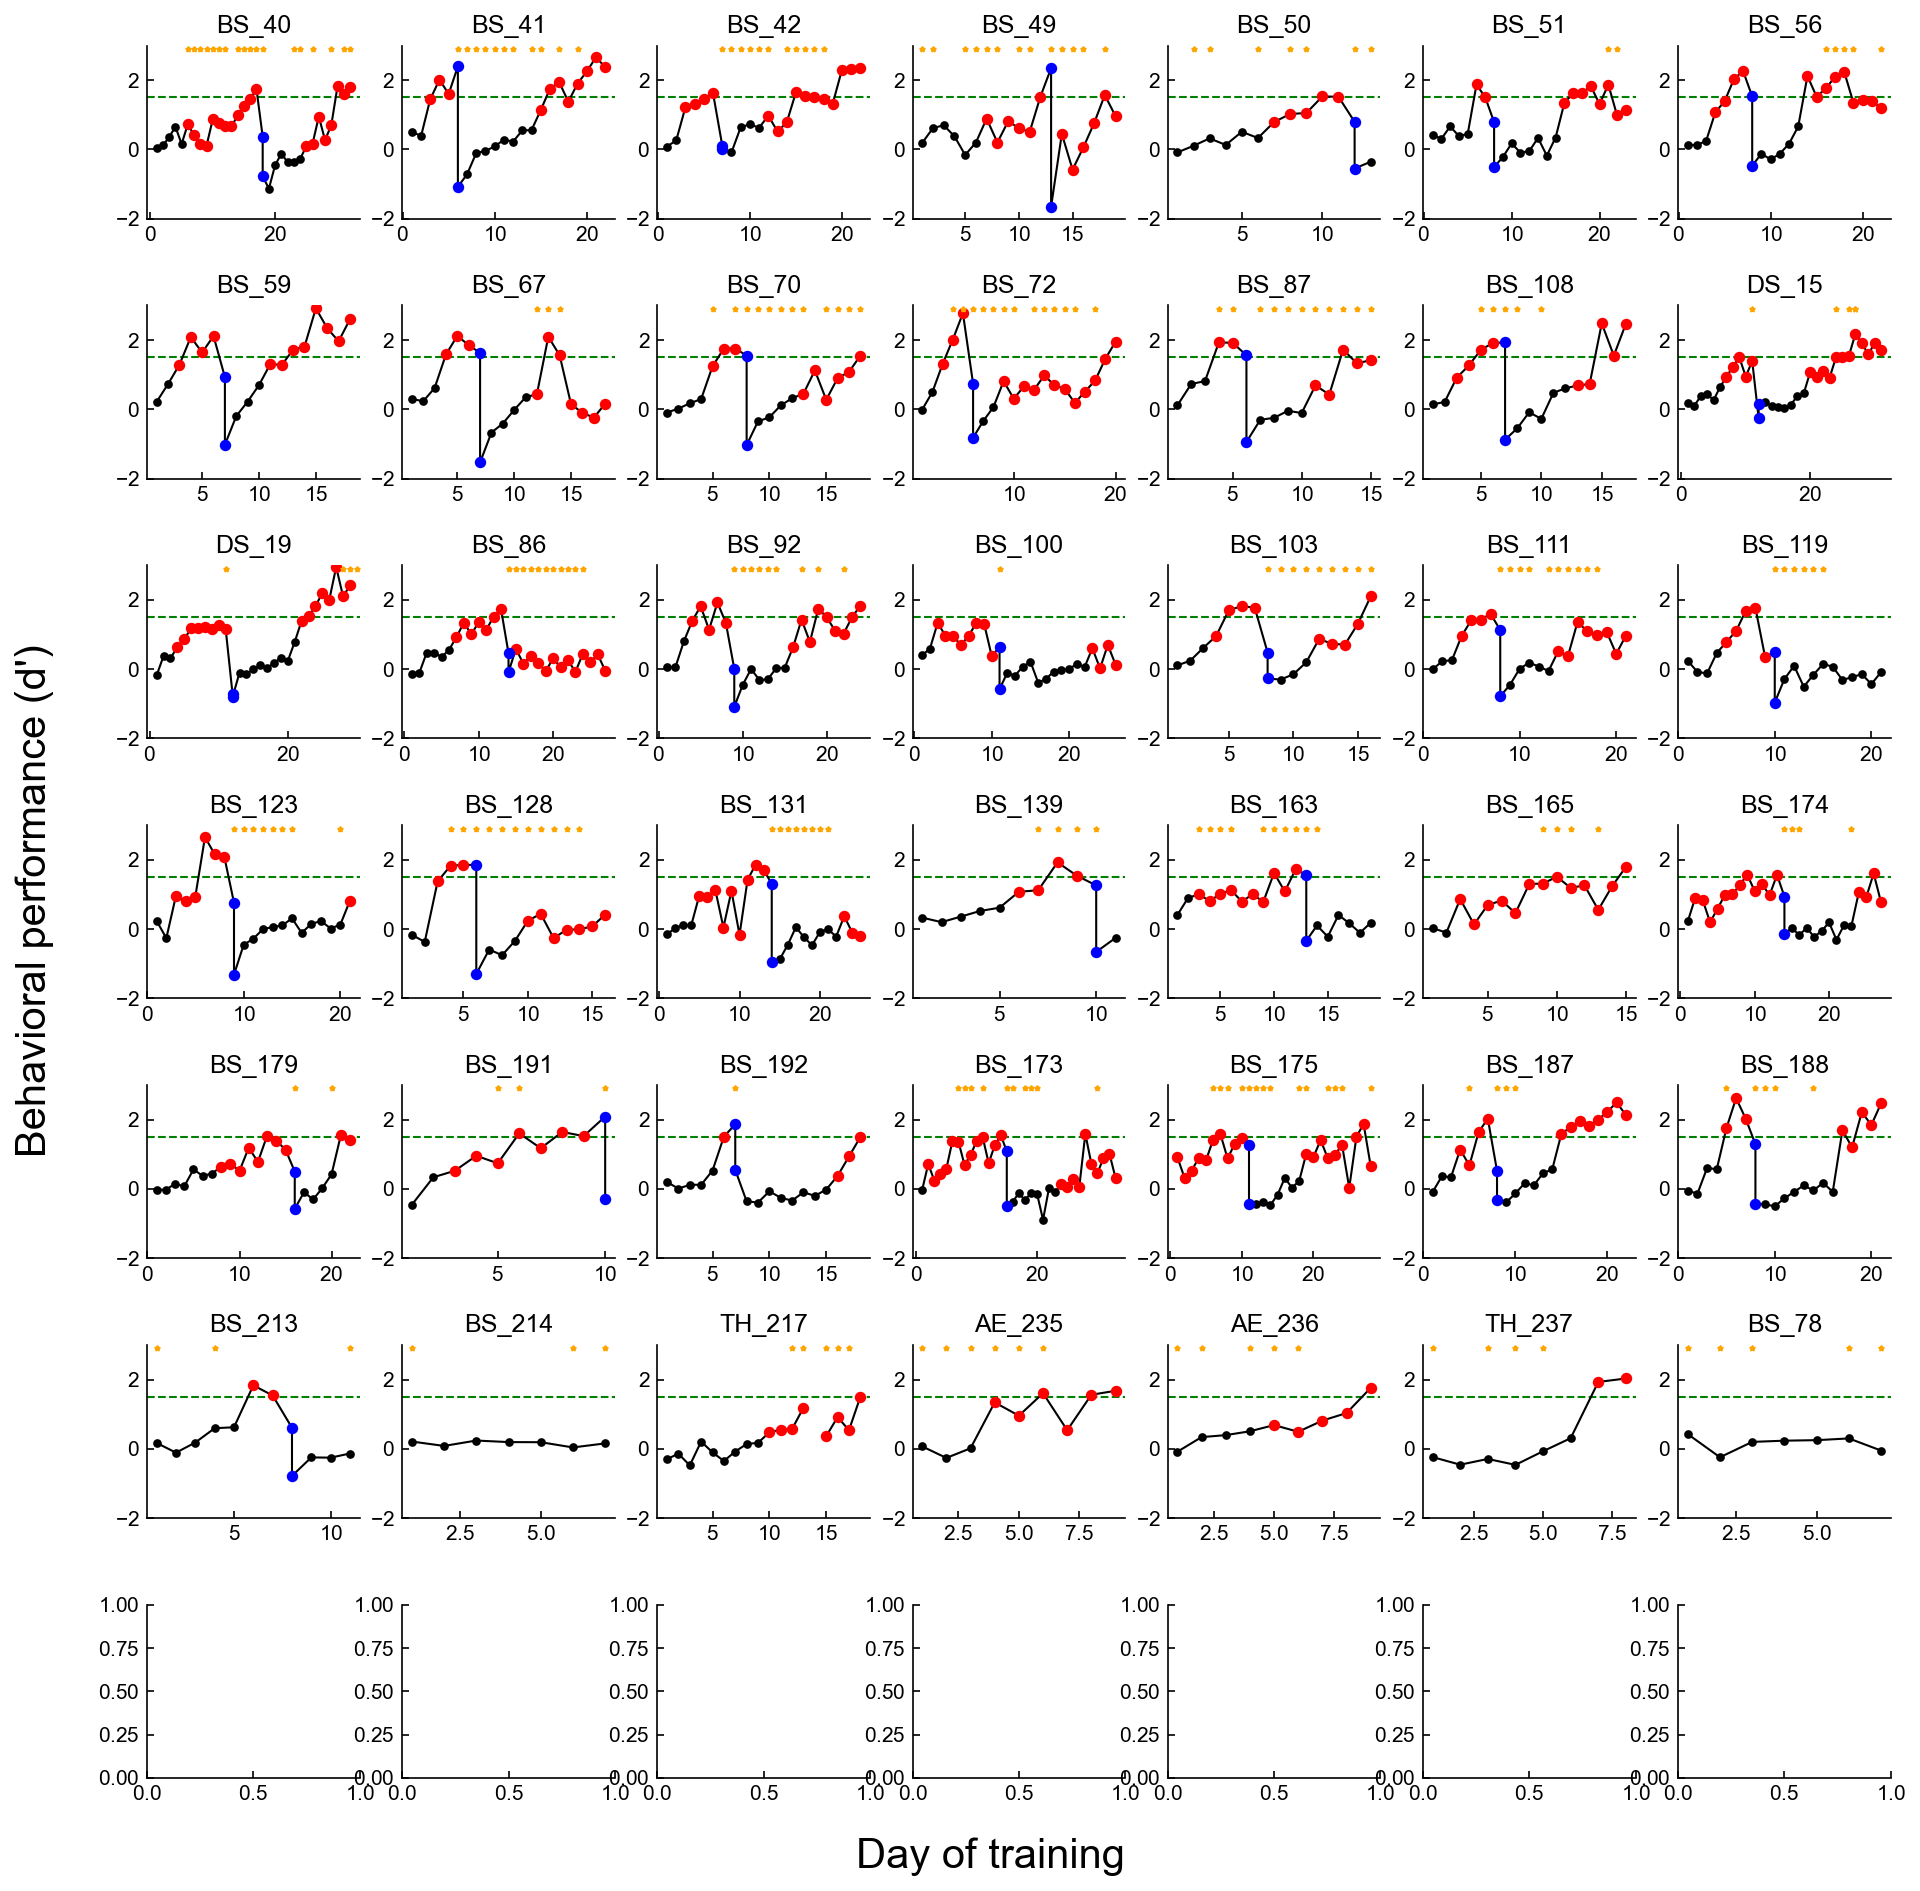

In [5]:
#filename = os.path.join('C:\\\\Users','insan','Desktop','DataForJMTTotal.csv')
filename = os.path.join('D:\\\\DataForJMTTotal.csv')
csv = pd.read_csv(filename)

postthresholds = dict()

plot=True
if plot:
    fig = plt.figure(figsize=(15,15))
    gs = fig.add_gridspec(7,7,hspace=0.5)
    axs = [plt.subplot(gs[i,j]) for i,j in product(range(7),range(7))]
    #plt.delaxes(axs[14])
    #plt.delaxes(axs[15])

premiddlecutoffs = dict()
postmiddlecutoffs = dict()
PERphases = dict()

for animalidx,animal in enumerate(animals):
    print(animal)
    PERphases[animal] = dict()
    
    condname = 'd\' ' + animal
    pc_condname = 'Percent correct ' + animal
    days = np.array(list(csv['Day']))
    cond = csv[condname]
    cond_pc = csv[pc_condname]
    
    #Correct for double reversal days
    for idx,day in enumerate(days):
        if day > animals[animal].reversal:
            days[idx] = day-1
            
        if day > animals[animal].reversal+1: #  +1 because the csv stores the switch day as two entries
            #Calculate PERphase
            PC = cond_pc[idx]
            if PC <= 47.5:
                PERphases[animal][day-1] = 'perseveration'
            elif PC >= 52.5:
                PERphases[animal][day-1] = 'refinement'
            else:
                PERphases[animal][day-1] = 'exploration'
            
    #days = days - animals[animal].reversal
    
    prereversaldays = []
    prereversaldps = []
    maxreversaldp = -np.Inf
    minreversaldp = np.Inf
    postreversaldays = []
    postreversaldps = []
    for idx,day in enumerate(days):
        if day < animals[animal].reversal or np.isnan(animals[animal].reversal):
            prereversaldays.append(day)
            prereversaldps.append(cond[idx])
        if day == animals[animal].reversal:
            maxreversaldp = max(cond[idx],maxreversaldp)
            minreversaldp = min(cond[idx],minreversaldp)
        if day > animals[animal].reversal and not np.isnan(cond[idx]):
            postreversaldays.append(day)
            postreversaldps.append(cond[idx])
            
    #Prereversal threshold
    maxperf = np.nanmax(np.concatenate((prereversaldps,[1.5])))
    minperf = np.nanmin(prereversaldps)
    prethreshold = minperf + 0.4*(maxperf-minperf)
    #Postreversal threshold
    try:
        maxperf = np.nanmax(np.concatenate((postreversaldps,[1.5])))
        minperf = np.nanmin(postreversaldps)
    except:
        print(animal+' has no post-reversal')
        maxperf = np.nan
        minperf = np.nan
    postthreshold = minperf + 0.4*(maxperf-minperf)
    
    postthresholds[animal] = postthreshold
    
    prereversaldays = np.array(prereversaldays)
    prereversaldps = np.array(prereversaldps)
    postreversaldays = np.array(postreversaldays)
    postreversaldps = np.array(postreversaldps)
    
    premiddlebool = np.greater_equal(prereversaldps,prethreshold)
    for idx,day in enumerate(prereversaldays):
        if premiddlebool[idx]:
            premiddlebool[idx:(len(premiddlebool)-1)].fill(True)
        #if not premiddlebool[idx]:
        #    premiddlebool[0:idx].fill(False)
    if np.any(premiddlebool):
        premiddlefirstday = np.min(prereversaldays[premiddlebool])
    else:
        premiddlefirstday = np.Inf
        
    print(premiddlefirstday)
                     
    postmiddlebool = np.greater_equal(postreversaldps,postthreshold)
    for idx,day in enumerate(postreversaldays):
        if postmiddlebool[idx]:
            postmiddlebool[idx:(len(postmiddlebool)-1)].fill(True)
        #if not postmiddlebool[idx]:
        #    postmiddlebool[0:idx].fill(False)
    if np.any(postmiddlebool):
        postmiddlefirstday = np.min(postreversaldays[postmiddlebool])
    else:
        postmiddlefirstday = np.Inf
    
    if animal == 'BS_95':
        premiddlefirstday = 4
    if animal == 'BS_49':
        premiddlefirstday = 7
    if animal in ['BS_83','BS_50']:
        postmiddlefirstday = np.Inf
    
    premiddlecutoffs[animal] = premiddlefirstday
    postmiddlecutoffs[animal] = postmiddlefirstday
    
    if plot:
        ax = axs[animalidx]    
        #All Days no color
        ax.plot(days,cond,color='k',lw=1)
        ax.scatter(days,cond,color='k',s=10,zorder=9)
        #Pre Middle
        premiddle = np.logical_and( np.greater_equal(days,premiddlefirstday), np.less(days,animals[animal].reversal) )
        ax.scatter(days[premiddle],cond[premiddle],color='r',s=20,zorder=10)
        #Post Middle
        postmiddle = np.greater_equal(days,postmiddlefirstday)
        ax.scatter(days[postmiddle],cond[postmiddle],color='r',s=20,zorder=10)
        #Switch
        switch = np.equal(days,animals[animal].reversal)
        ax.scatter(days[switch],cond[switch],color='b',s=20,zorder=10)

        xlims = ax.get_xlim()
        ax.plot(xlims,[1.5,1.5],c='g',linestyle='--',lw=1,zorder=-10)
        ax.set_xlim(xlims)
        ax.set_ylim([-2,3])
        
        days_recorded = training_days_recorded[animal]
        ax.scatter(days_recorded,np.ones_like(days_recorded)*2.9,s=5,marker='*',color='orange',zorder=11)

        ax.set_title(animal)
        
fig.text(0.075, 0.5, 'Behavioral performance (d\')', ha='center', va='center', rotation='vertical',fontsize=20)
fig.text(0.5,0.075, 'Day of training', ha='center', va='center', rotation='horizontal',fontsize=20)

if plot:
    #plt.savefig(os.path.join('D:\\\\TempFigures','EIL Learning Phases.pdf'),transparent=False,facecolor="white")
    pass

In [6]:
#this function calculates pval for one cluster(one cell)
def calculate_NCR_CR_pval(sessionfile,clust):

    #convert window(100ms) in samples
    sessionfile.meta.fs #30000 samples / second from blackrock
    window = sessionfile.meta.fs * 0.1
    trials_to_use = sessionfile.trim[clust].trimmed_trials

    #create array for stimulus period
    #tone play start time
    onset_window_start_time = np.zeros(len(trials_to_use))
    for idx, trial in enumerate(trials_to_use):
        onset_window_start_time[idx] = sessionfile.trials.starts[trial]

    #tone play end time
    onset_window_end_time = onset_window_start_time + window
    #offset window start time
    offset_window_start_time = onset_window_end_time
    #offset window end time
    offset_window_end_time = offset_window_start_time + window
    #stimulus array
    stimulus_array = np.zeros([len(onset_window_start_time),2,2])
    for i in range(len(onset_window_start_time)):
        stimulus_array[i] = [[onset_window_start_time[i],onset_window_end_time[i]],
                             [offset_window_start_time[i],offset_window_end_time[i]]
                            ]

    #create array for baseline period
    base_window1_start = onset_window_start_time - 3*window
    base_window1_end = onset_window_start_time - 2*window
    base_window2_start = base_window1_end
    base_window2_end = onset_window_start_time - 1*window
    base_window3_start = base_window2_end
    base_window3_end = onset_window_start_time

    baseline_array = np.zeros([len(base_window1_start),3,2])
    for i in range(len(onset_window_start_time)):
        baseline_array[i] = [[base_window1_start[i],base_window1_end[i]],
                             [base_window2_start[i],base_window2_end[i]],
                             [base_window3_start[i],base_window3_end[i]],
                            ]

    #evaluate spike count within stimulus window
    spikecounts_stimuluswindow = np.zeros((len(onset_window_start_time),2))

    for idx, t in enumerate(stimulus_array):
        #print(t[0][0])

        #spike count from onset window
        spikecount_onsetwindow = len(ilep.getSpikeTimes(sessionfile,clust=clust,starttime=t[0][0],endtime=t[0][1]))

        #spike count from offset window
        spikecount_offsetwindow = len(ilep.getSpikeTimes(sessionfile,clust=clust,starttime=t[1][0],endtime=t[1][1]))

        spikecounts_stimuluswindow[idx][0]=spikecount_onsetwindow
        spikecounts_stimuluswindow[idx][1]=spikecount_offsetwindow

    #evaluate spike count within baseline window
    spikecounts_basewindow = np.zeros((len(onset_window_start_time),3))

    for idx, t in enumerate(baseline_array):
        #print(t[0][0])

        #spike count from window1
        spikecount_base_window1 = len(ilep.getSpikeTimes(sessionfile,clust=clust,starttime=t[0][0],endtime=t[0][1]))

        #spike count from window2
        spikecount_base_window2 = len(ilep.getSpikeTimes(sessionfile,clust=clust,starttime=t[1][0],endtime=t[1][1]))

        #spike count from window3
        spikecount_base_window3 = len(ilep.getSpikeTimes(sessionfile,clust=clust,starttime=t[2][0],endtime=t[2][1]))

        spikecounts_basewindow[idx][0]=spikecount_base_window1
        spikecounts_basewindow[idx][1]=spikecount_base_window2
        spikecounts_basewindow[idx][2]=spikecount_base_window3

    ###### CODE BELOW HERE SHOULD LOOP 5000 TIMES 
    iterations = 5000
    #spikecounts_diff_mean_arr = []

    CR_evok_appear=0
    CR_sup_appear=0
    NCR_appear=0

    for i in range(iterations):

        #1.subsampled 90% of the spike count changes from baseline,
        #2.calculated the mean of these values, repeated this process 5000 times 

        #1.
        #subsampled 90% trials
        trials = range(len(spikecounts_stimuluswindow))
        trials_perm = np.random.permutation(trials)
        trials_subsamp = trials_perm[range(int(0.9*len(trials_perm)))]

        #calculate spike count changes from baseline in the subsample
        spikecounts_diff = []
        for trial_idx in trials_subsamp:
            random_stimulus = spikecounts_stimuluswindow[trial_idx][np.random.randint(2)]
            random_base = spikecounts_basewindow[trial_idx][np.random.randint(3)]
            spikecounts_diff.append(random_stimulus-random_base)

        #2. 
        #calculate the mean of the spike counts diff  
        spikecounts_diff_mean = np.mean(spikecounts_diff)
        #calculate the # of appearance in each categotiry in 5000 iterations
        if spikecounts_diff_mean > 0.1:
            CR_evok_appear+=1
        elif spikecounts_diff_mean < -0.1:
            CR_sup_appear+=1
        else:
            NCR_appear+=1
            
    p_value_evoked = CR_evok_appear/(iterations)
    p_value_suppressed = CR_sup_appear/(iterations)
    p_value_NCR = NCR_appear/(iterations)
    return p_value_evoked, p_value_suppressed, p_value_NCR

In [9]:
EnumSession = []
EnumClust = []
sessions = os.listdir(act_directory)
for session in tqdm(sessions):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    if sessionfile.meta.task == 'passive no behavior':
        continue
        
    if sessionfile.meta.task in ['tuning nonreversal','tuning switch','tuning reversal']:
        continue
        
    if sessionfile.meta.region != 'AC':
        continue
    
    for clust in sessionfile.clusters.good:
        EnumSession.append(session)
        EnumClust.append(clust)

100%|██████████| 517/517 [00:02<00:00, 211.01it/s]


In [10]:
regions = np.full_like(EnumSession,np.nan)
for idx,session in enumerate(tqdm(EnumSession)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    regions[idx] = sessionfile.meta.region

100%|██████████| 2797/2797 [00:15<00:00, 183.51it/s]


In [11]:
EILphases = np.full_like(EnumSession,np.nan)
error_animals = []

for idx,session in enumerate(tqdm(EnumSession)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    try:
        if sessionfile.meta.task in ['switch','opto switch','tuning switch']:
            EILphases[idx] = 'switch'

        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and sessionfile.meta.day_of_training < premiddlecutoffs[sessionfile.meta.animal]:
            EILphases[idx] = 'pre early'
        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and sessionfile.meta.day_of_training < firstExpert.pre[sessionfile.meta.animal] and sessionfile.meta.day_of_training >= premiddlecutoffs[sessionfile.meta.animal]:
            EILphases[idx] = 'pre late'
        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and sessionfile.meta.day_of_training >= firstExpert.pre[sessionfile.meta.animal]:
            EILphases[idx] = 'pre expert'

        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal'] and sessionfile.meta.day_of_training < postmiddlecutoffs[sessionfile.meta.animal]:
            EILphases[idx] = 'post early'
        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal'] and sessionfile.meta.day_of_training < firstExpert.post[sessionfile.meta.animal] and sessionfile.meta.day_of_training >= postmiddlecutoffs[sessionfile.meta.animal]:
            EILphases[idx] = 'post late'
        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal'] and sessionfile.meta.day_of_training >= firstExpert.post[sessionfile.meta.animal]:
            EILphases[idx] = 'post expert'
    except Exception as e:
        #print(ilep.generateDateString(sessionfile))
        error_animals.append(sessionfile.meta.animal)
        pass
                             
error_animals = np.unique(error_animals)
print('errors for: '+str(error_animals))

100%|██████████| 2797/2797 [00:15<00:00, 185.02it/s]

errors for: ['BS_113' 'BS_33' 'BS_73' 'BS_83' 'BS_85' 'BS_95' 'DS_16' 'DS_17' 'DS_22']


In [336]:
FRmod_preearly = []
FRmod_prelate = []
FRmod_preexpert = []
FRmod_postearly = []
FRmod_postlate = []
FRmod_postexpert = []

FRb_preearly = []
FRb_prelate = []
FRb_preexpert = []
FRb_postearly = []
FRb_postlate = []
FRb_postexpert = []

FRe_preearly = []
FRe_prelate = []
FRe_preexpert = []
FRe_postearly = []
FRe_postlate = []
FRe_postexpert = []

FReT_preearly = []
FReT_prelate = []
FReT_preexpert = []
FReT_postearly = []
FReT_postlate = []
FReT_postexpert = []

FReNT_preearly = []
FReNT_prelate = []
FReNT_preexpert = []
FReNT_postearly = []
FReNT_postlate = []
FReNT_postexpert = []

FRt_preearly = []
FRt_prelate = []
FRt_preexpert = []
FRt_postearly = []
FRt_postlate = []
FRt_postexpert = []

preearly_animals = []
prelate_animals = []
preexpert_animals = []
postearly_animals = []
postlate_animals = []
postexpert_animals = []

ramping_preearly = []
ramping_prelate = []
ramping_preexpert = []
ramping_postearly = []
ramping_postlate = []
ramping_postexpert = []

category_preearly = []
category_prelate = []
category_preexpert = []
category_postearly = []
category_postlate = []
category_postexpert = []

animalstouse = np.concatenate((dualanimalnames,unuseddualanimals,tuninganimalnames))
print(animalstouse)

cellstouseFR = 'all cells'
#cellstouseFR = 'task encoders'

EnumCategory = []

for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    if not regions[idx] == 'AC':
        continue
    
    #Currently not active as tuning curve animals have not been decoded
    if cellstouseFR == 'task encoders':
        if not np.isfinite(accuracies[idx]) or pvals[idx] > 0.05 or accuracies[idx] < task_encoder_threshold:
            continue
            
    if not sessionfile.meta.animal in animalstouse:
        continue
    if sessionfile.meta.animal in tuninganimalnames:
        continue
    #if sessionfile.meta.animal == 'TH_217':
    #    continue
        
    if sessionfile.meta.animal == 'BS_67' and sessionfile.meta.day_of_training >= 15:
        continue
        
    if sessionfile.meta.animal == 'BS_50' and sessionfile.meta.day_of_training >= 13:
        continue
        
    if sessionfile.meta.animal == 'BS_78' and sessionfile.meta.day_of_training >= 3:
        continue
        
    if sessionfile.meta.animal == 'BS_214' and sessionfile.meta.day_of_training >= 3:
        continue
        
    if sessionfile.responsiveness[clust]['all_trials'].FR < sessionfile.responsiveness[clust]['all_trials'].FRbaseline:
        #print('excluded')
        #continue
        pass
    
    if not hasattr(sessionfile.responsiveness[clust]['all_trials'],'rampingMod'):
        continue
    
    #p_ev,p_sup,p_ncr = calculate_NCR_CR_pval(sessionfile,clust)
    #category = 'Inconclusive'
    #if p_ev > 0.95 or p_sup > 0.95:
    #    if np.abs(sessionfile.responsiveness[clust]['slow_go_response'].rampingModNorm > 0.5):
    #        category = 'Both'
    #    else:
    #        category = 'Stimulus'
    #elif p_ncr > 0.95:
    #    if np.abs(sessionfile.responsiveness[clust]['go_response'].rampingModNorm > 0.5):
    #        category = 'Ramping'
    #    else:
    #        category = 'NCR'
    #EnumCategory.append(category)
    #    
    ##if not sessionfile.meta.animal in ['BS_213','BS_214']:
    ##    continue
    #
    ##else:
    ##    print(ilep.generateDateString(sessionfile))
    ##    print(len(sessionfile.clusters.good))
    #    
    ##if np.isnan(accuracies[idx]):
    ##    continue
        
    if EILphases[idx] == 'pre early':
        FRb_preearly.append(sessionfile.responsiveness[clust]['all_trials'].FRbaseline)
        FRe_preearly.append(sessionfile.responsiveness[clust]['all_trials'].FR)
        FRmod_preearly.append(sessionfile.responsiveness[clust]['all_trials'].FRmodulation)
        FReT_preearly.append(sessionfile.responsiveness[clust]['target_tone'].FR)
        FReNT_preearly.append(sessionfile.responsiveness[clust]['nontarget_tone'].FR)
        ramping_preearly.append(sessionfile.responsiveness[clust]['go_response'].rampingMod)
        #category_preearly.append(category)
        #FRt_preearly.append( (sessionfile.responsiveness[clust]['target_tone'].FRmodulation-sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) / max(sessionfile.responsiveness[clust]['target_tone'].FRmodulation,sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation))
        #temp = ( (sessionfile.responsiveness[clust]['target_tone'].FRmodulation-sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) / (sessionfile.responsiveness[clust]['target_tone'].FRmodulation+sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) )
        FRt_preearly.append( (sessionfile.responsiveness[clust]['target_tone'].FRmodulation-sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) / (sessionfile.responsiveness[clust]['target_tone'].FRmodulation+sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) )        
        #Dec_preearly.append(accuracies[idx])
        preearly_animals.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'pre late':
        FRb_prelate.append(sessionfile.responsiveness[clust]['all_trials'].FRbaseline)
        FRe_prelate.append(sessionfile.responsiveness[clust]['all_trials'].FR)
        FRmod_prelate.append(sessionfile.responsiveness[clust]['all_trials'].FRmodulation)
        FReT_prelate.append(sessionfile.responsiveness[clust]['target_tone'].FR)
        FReNT_prelate.append(sessionfile.responsiveness[clust]['nontarget_tone'].FR)
        ramping_prelate.append(sessionfile.responsiveness[clust]['go_response'].rampingMod)
        #category_prelate.append(category)
        #FRt_preint.append( (sessionfile.responsiveness[clust]['target_tone'].FRmodulation-sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) / max(sessionfile.responsiveness[clust]['target_tone'].FRmodulation,sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation))
        FRt_prelate.append( (sessionfile.responsiveness[clust]['target_tone'].FRmodulation-sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) / (sessionfile.responsiveness[clust]['target_tone'].FRmodulation+sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) )                
        #Dec_preint.append(accuracies[idx])
        prelate_animals.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'pre expert':
        FRb_preexpert.append(sessionfile.responsiveness[clust]['all_trials'].FRbaseline)
        FRe_preexpert.append(sessionfile.responsiveness[clust]['all_trials'].FR)
        FRmod_preexpert.append(sessionfile.responsiveness[clust]['all_trials'].FRmodulation)
        FReT_preexpert.append(sessionfile.responsiveness[clust]['target_tone'].FR)
        FReNT_preexpert.append(sessionfile.responsiveness[clust]['nontarget_tone'].FR)
        ramping_preexpert.append(sessionfile.responsiveness[clust]['go_response'].rampingMod)
        #category_preexpert.append(category)
        #FRt_prelate.append( (sessionfile.responsiveness[clust]['target_tone'].FRmodulation-sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) / max(sessionfile.responsiveness[clust]['target_tone'].FRmodulation,sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation))
        FRt_preexpert.append( (sessionfile.responsiveness[clust]['target_tone'].FRmodulation-sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) / (sessionfile.responsiveness[clust]['target_tone'].FRmodulation+sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) )
        #Dec_prelate.append(accuracies[idx])
        preexpert_animals.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'post early':
        FRb_postearly.append(sessionfile.responsiveness[clust]['all_trials'].FRbaseline)
        FRe_postearly.append(sessionfile.responsiveness[clust]['all_trials'].FR)
        FRmod_postearly.append(sessionfile.responsiveness[clust]['all_trials'].FRmodulation)
        FReT_postearly.append(sessionfile.responsiveness[clust]['target_tone'].FR)
        FReNT_postearly.append(sessionfile.responsiveness[clust]['nontarget_tone'].FR)
        ramping_postearly.append(sessionfile.responsiveness[clust]['go_response'].rampingMod)
        #category_postearly.append(category)
        #FRt_postearly.append( (sessionfile.responsiveness[clust]['target_tone'].FRmodulation-sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) / max(sessionfile.responsiveness[clust]['target_tone'].FRmodulation,sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation))
        FRt_postearly.append( (sessionfile.responsiveness[clust]['target_tone'].FRmodulation-sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) / (sessionfile.responsiveness[clust]['target_tone'].FRmodulation+sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) )
        #Dec_postearly.append(accuracies[idx])
        postearly_animals.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'post late':
        FRb_postlate.append(sessionfile.responsiveness[clust]['all_trials'].FRbaseline)
        FRe_postlate.append(sessionfile.responsiveness[clust]['all_trials'].FR)
        FRmod_postlate.append(sessionfile.responsiveness[clust]['all_trials'].FRmodulation)
        FReT_postlate.append(sessionfile.responsiveness[clust]['target_tone'].FR)
        FReNT_postlate.append(sessionfile.responsiveness[clust]['nontarget_tone'].FR)
        ramping_postlate.append(sessionfile.responsiveness[clust]['go_response'].rampingMod)
        #category_postlate.append(category)
        #FRt_postint.append( (sessionfile.responsiveness[clust]['target_tone'].FRmodulation-sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) / max(sessionfile.responsiveness[clust]['target_tone'].FRmodulation,sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation))
        FRt_postlate.append( (sessionfile.responsiveness[clust]['target_tone'].FRmodulation-sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) / (sessionfile.responsiveness[clust]['target_tone'].FRmodulation+sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) )
        #Dec_postint.append(accuracies[idx])
        postlate_animals.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'post expert':
        FRb_postexpert.append(sessionfile.responsiveness[clust]['all_trials'].FRbaseline)
        FRe_postexpert.append(sessionfile.responsiveness[clust]['all_trials'].FR)
        FRmod_postexpert.append(sessionfile.responsiveness[clust]['all_trials'].FRmodulation)
        FReT_postexpert.append(sessionfile.responsiveness[clust]['target_tone'].FR)
        FReNT_postexpert.append(sessionfile.responsiveness[clust]['nontarget_tone'].FR)
        ramping_postexpert.append(sessionfile.responsiveness[clust]['go_response'].rampingMod)
        #category_postexpert.append(category)
        #FRt_postlate.append( (sessionfile.responsiveness[clust]['target_tone'].FRmodulation-sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) / max(sessionfile.responsiveness[clust]['target_tone'].FRmodulation,sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation))
        FRt_postexpert.append( (sessionfile.responsiveness[clust]['target_tone'].FRmodulation-sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) / (sessionfile.responsiveness[clust]['target_tone'].FRmodulation+sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) )
        #Dec_postlate.append(accuracies[idx])
        postexpert_animals.append(sessionfile.meta.animal)
        
FRb_preearly = np.array(FRb_preearly)
FRb_prelate = np.array(FRb_prelate)
FRb_preexpert = np.array(FRb_preexpert)
FRb_postearly = np.array(FRb_postearly)
FRb_postlate = np.array(FRb_postlate)
FRb_postexpert = np.array(FRb_postexpert)

FRe_preearly = np.array(FRe_preearly)
FRe_prelate = np.array(FRe_prelate)
FRe_preexpert = np.array(FRe_preexpert)
FRe_postearly = np.array(FRe_postearly)
FRe_postlate = np.array(FRe_postlate)
FRe_postexpert = np.array(FRe_postexpert)

FRmod_preearly = np.array(FRmod_preearly)
FRmod_prelate = np.array(FRmod_prelate)
FRmod_preexpert = np.array(FRmod_preexpert)
FRmod_postearly = np.array(FRmod_postearly)
FRmod_postlate = np.array(FRmod_postlate)
FRmod_postexpert = np.array(FRmod_postexpert)

FReT_preearly = np.array(FReT_preearly)
FReT_prelate = np.array(FReT_prelate)
FReT_preexpert = np.array(FReT_preexpert)
FReT_postearly = np.array(FReT_postearly)
FReT_postlate = np.array(FReT_postlate)
FReT_postexpert = np.array(FReT_postexpert)

FReNT_preearly = np.array(FReNT_preearly)
FReNT_prelate = np.array(FReNT_prelate)
FReNT_preexpert = np.array(FReNT_preexpert)
FReNT_postearly = np.array(FReNT_postearly)
FReNT_postlate = np.array(FReNT_postlate)
FReNT_postexpert = np.array(FReNT_postexpert)

FRt_preearly = np.array(FRt_preearly)
FRt_prelate = np.array(FRt_prelate)
FRt_preexpert = np.array(FRt_preexpert)
FRt_postearly = np.array(FRt_postearly)
FRt_postlate = np.array(FRt_postlate)
FRt_postexpert = np.array(FRt_postexpert)

ramping_preearly = np.array(ramping_preearly)
ramping_prelate = np.array(ramping_prelate)
ramping_preexpert = np.array(ramping_preexpert)
ramping_postearly = np.array(ramping_postearly)
ramping_postlate = np.array(ramping_postlate)
ramping_postexpert = np.array(ramping_postexpert)

FRmodInd_preearly = np.sqrt(np.power(FRmod_preearly,2)+np.power(ramping_preearly,2))
FRmodInd_prelate = np.sqrt(np.power(FRmod_prelate,2)+np.power(ramping_prelate,2))
FRmodInd_preexpert = np.sqrt(np.power(FRmod_preexpert,2)+np.power(ramping_preexpert,2))
FRmodInd_postearly = np.sqrt(np.power(FRmod_postearly,2)+np.power(ramping_postearly,2))
FRmodInd_postlate = np.sqrt(np.power(FRmod_postlate,2)+np.power(ramping_postlate,2))
FRmodInd_postexpert = np.sqrt(np.power(FRmod_postexpert,2)+np.power(ramping_postexpert,2))

ramping_preearly = ramping_preearly[np.isfinite(ramping_preearly)]
ramping_prelate = ramping_prelate[np.isfinite(ramping_prelate)]
ramping_preexpert = ramping_preexpert[np.isfinite(ramping_preexpert)]
ramping_postearly = ramping_postearly[np.isfinite(ramping_postearly)]
ramping_postlate = ramping_postlate[np.isfinite(ramping_postlate)]
ramping_postexpert = ramping_postexpert[np.isfinite(ramping_postexpert)]

FRmodInd_preearly = FRmodInd_preearly[np.isfinite(FRmodInd_preearly)]
FRmodInd_prelate = FRmodInd_prelate[np.isfinite(FRmodInd_prelate)]
FRmodInd_preexpert = FRmodInd_preexpert[np.isfinite(FRmodInd_preexpert)]
FRmodInd_postearly = FRmodInd_postearly[np.isfinite(FRmodInd_postearly)]
FRmodInd_postlate = FRmodInd_postlate[np.isfinite(FRmodInd_postlate)]
FRmodInd_postexpert = FRmodInd_postexpert[np.isfinite(FRmodInd_postexpert)]

#Dec_preearly = np.array(Dec_preearly)
#Dec_preint = np.array(Dec_preint)
#Dec_prelate = np.array(Dec_prelate)
#Dec_postearly = np.array(Dec_postearly)
#Dec_postint = np.array(Dec_postint)
#Dec_postlate = np.array(Dec_postlate)

22it [00:00, 213.54it/s]

['BS_40' 'BS_41' 'BS_42' 'BS_49' 'BS_50' 'BS_51' 'BS_56' 'BS_59' 'BS_67'
 'BS_70' 'BS_72' 'BS_87' 'BS_108' 'DS_15' 'DS_19' 'BS_78' 'BS_173'
 'BS_175' 'BS_187' 'BS_188' 'BS_213' 'BS_214' 'TH_217' 'AE_235' 'AE_236'
 'TH_237']


2797it [00:17, 163.40it/s]


In [337]:
#number of animals in each learning phase

preearly_animals = np.unique(preearly_animals)
prelate_animals = np.unique(prelate_animals)
preexpert_animals = np.unique(preexpert_animals)
postearly_animals = np.unique(postearly_animals)
postlate_animals = np.unique(postlate_animals)
postexpert_animals = np.unique(postexpert_animals)

preearly_animals_num = len(preearly_animals)
prelate_animals_num = len(prelate_animals)
preexpert_animals_num = len(preexpert_animals)
postearly_animals_num = len(postearly_animals)
postlate_animals_num = len(postlate_animals)
postexpert_animals_num = len(postexpert_animals)

In [26]:
data = SimpleNamespace()
data.preearly = category_preearly
data.prelate = category_prelate
data.preexpert = category_preexpert
data.postearly = category_postearly
data.postlate = category_postlate
data.postexpert = category_postexpert
filename = 'D:\\\\tempcategorystore.pickle'
with open(filename, 'wb') as f:
        pickle.dump(data, f, protocol=pickle.HIGHEST_PROTOCOL)

In [27]:
filename = 'D:\\\\tempcategorystore.pickle'
with open(filename, 'rb') as f:
        data_loaded = pickle.load(f)

In [24]:
data = [ramping_preearly,ramping_prelate,ramping_preexpert,ramping_postearly,ramping_postlate,ramping_postexpert]
for col in data:
    print(np.mean(np.isnan(col)))

0.16071428571428573
0.0
0.0
0.0
0.003816793893129771
0.0


# Stimulus Modulation

baseline = 3.4758144364751598


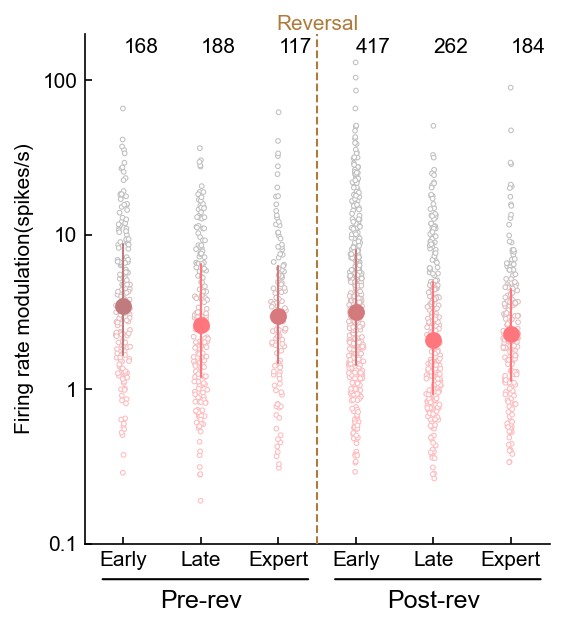

In [365]:
#Firing rate modulation graphs

size=5

FRmod_baseline_median = np.nanmedian(np.abs(FRmod_preearly))
print('baseline = '+str(FRmod_baseline_median))

fig, ax = plt.subplots(figsize=(4,4.5))
data = [FRmod_preearly,FRmod_prelate,FRmod_preexpert,FRmod_postearly,FRmod_postlate,FRmod_postexpert]
data = [np.abs(column[np.isfinite(column)]) for column in data]
#num_animal = [preearly_animal_num,prelate_animal_num,preexpert_animal_num,postearly_animal_num,postlate_animal_num,postexpert_animal_num]
labels = ['Early','Late','Expert','Early','Late','Expert']
numCon = len(data)
X = [np.ones(len(l))*idx for idx,l in enumerate(data)]

_,Y = ilep.violin(np.concatenate(X),np.concatenate(data),width=0.25)
X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data)),width=0.25)
colors = NCR_CR_cmap((Y-1)/5)

ax.scatter(X, Y, s=size, ec=colors, fc='white', lw=0.5,zorder=-10)
ax.set_yscale('log',subs=[])

#Plot summary
for idx,column in enumerate(data):
    percentCR = np.nanmean(np.greater(column,FRmod_baseline_median))*100
    
    eye_color=NCR_CR_cmap((percentCR-40)/20)
    
    r,g,b = mpl.colors.to_rgb(eye_color)
    h,l,s = colorsys.rgb_to_hls(r,g,b)
    #border_color=colorsys.hls_to_rgb(h,l*0.5,s)
    border_color=colorsys.hls_to_rgb(h,l,s)

    summary_size=50
    summary_width=1
    
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    
    ax.scatter([idx], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx, idx], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')

ax.axvline(2.5,color=SWITCH_COLOR,linestyle='--',zorder=10,lw=1)

ax.set_ylim([0.1,200])
ax.set_yticks([0.1,1,10,100])
ax.set_yticklabels(['0.1','1','10','100'])
ax.set_ylabel('Firing rate modulation(spikes/s)')

ax.set_xlim([-0.5,5.5])
ax.set_xticks(range(numCon))
ax.set_xticklabels(labels)
ax.set_xlim(ax.get_xlim())

# #numbers
#cells
# for idx,column in enumerate(data):
#     ax.text(idx,120,str(len(column)))
# #animals
# for idx,column in enumerate(num_animal):
#     ax.text(idx,95,str(column))
    
ax.fill_between(ax.get_xlim(),[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]]*2,color='white',alpha=0.5,zorder=-5)
#ax.axhline(ramping_baseline_median,color='k',linestyle='--',lw=1,zorder=-4)
ax.text(2.5,ax.get_ylim()[1],'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='bottom')
#statistics
#ax.text(1,105,str('n.s.'))
#ax.text(2,105,str('n.s.'))
#ax.text(3,105,str('n.s.'))
#ax.text(4,105,str('n.s.'))
#ax.text(5,105,str('n.s.'))

ax.text(0,150,str(len(FRmod_preearly)))
ax.text(1,150,str(len(FRmod_prelate)))
ax.text(2,150,str(len(FRmod_preexpert)))
ax.text(3,150,str(len(FRmod_postearly)))
ax.text(4,150,str(len(FRmod_postlate)))
ax.text(5,150,str(len(FRmod_postexpert)))

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
ax.text(xtick_pos_pre, 0.05, 'Pre-rev', ha='center', va='top', fontsize=12)
ax.text(xtick_pos_post, 0.05, 'Post-rev', ha='center', va='top',  fontsize=12)
ax.annotate('', xy=(0.03, -0.07), xycoords='axes fraction', xytext=(0.49, -0.07),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -0.07), xycoords='axes fraction', xytext=(0.99, -0.07),arrowprops=dict(arrowstyle='-', color='black'))

#plt.tight_layout()
fig.savefig(os.path.join('D:\\\\Figures','Ramping Figures','FR modulations','AC stimulus modulation all cells over learning.png'),transparent=False,facecolor="white")
fig.savefig(os.path.join('D:\\\\Figures','Ramping Figures','FR modulations','AC stimulus modulation all cells over learning.pdf'),transparent=False,facecolor="white")

In [369]:
data = SimpleNamespace(prereversal_early=np.abs(FRmod_preearly),
                      prereversal_late=np.abs(FRmod_prelate),
                      prereversal_expert=np.abs(FRmod_preexpert),
                      postreversal_early=np.abs(FRmod_postearly),
                      postreversal_late=np.abs(FRmod_postlate),
                      postreversal_expert=np.abs(FRmod_postexpert)
                     )

In [370]:
phase = len(data.prereversal_early)*["pre-early"] + len(data.prereversal_late)*["pre-late"] + len(data.prereversal_expert)*["pre-expert"] \
        + len(data.postreversal_early)*["post-early"] + len(data.postreversal_late)*["post-late"] + len(data.postreversal_expert)*["post-expert"]
context = len(data.prereversal_early)*["pre"] + len(data.prereversal_late)*["pre"] + len(data.prereversal_expert)*["pre"] \
        + len(data.postreversal_early)*["post"] + len(data.postreversal_late)*["post"] + len(data.postreversal_expert)*["post"]
mod = (np.concatenate([data.prereversal_early, data.prereversal_late, data.prereversal_expert, data.postreversal_early, data.postreversal_late, data.postreversal_expert]))

df = pd.DataFrame({"phase": phase, "context": context, "FR_mod": mod})
#df.to_csv('C:\\\\Users\\insan\\Desktop\\DataForStatsTestRamping.csv')

In [371]:
pg.anova(data=df, dv='FR_mod', between=['phase'], detailed=True)

,Source,SS,DF,MS,F,p-unc,np2
0,phase,2446.38851,5,489.277702,5.4476,0.000057,0.020069
1,Within,119454.31159,1330,89.815272,NaN,NaN,NaN


In [372]:
context_results = pg.pairwise_tests(data=df, dv='FR_mod', between=['phase'], parametric=True, padjust='fdr_bh')

In [373]:
# Conducting pairwise tests using Benjamini/Hochberg FDR correction to Mann-Whitney U

pairwise_mwu = pg.pairwise_tests(data=df, dv='FR_mod', between="phase", padjust="fdr_bh", parametric=False, )

pairwise_mwu[pairwise_mwu["p-corr"] <= 0.05][["A", "B", "p-corr", "hedges"]]
#pairwise_mwu[:][["A", "B","p-unc", "p-corr", "hedges"]]

,A,B,p-corr,hedges
0,post-early,post-expert,0.001098,0.281049
1,post-early,post-late,0.000113,0.290981
6,post-expert,pre-early,0.000254,-0.286931
7,post-expert,pre-expert,0.042523,-0.183648
9,post-late,pre-early,0.000113,-0.315570
10,post-late,pre-expert,0.030660,-0.200405
13,pre-early,pre-late,0.022591,0.235622


# Ramping Modulation

baseline = 1.1528258064516133


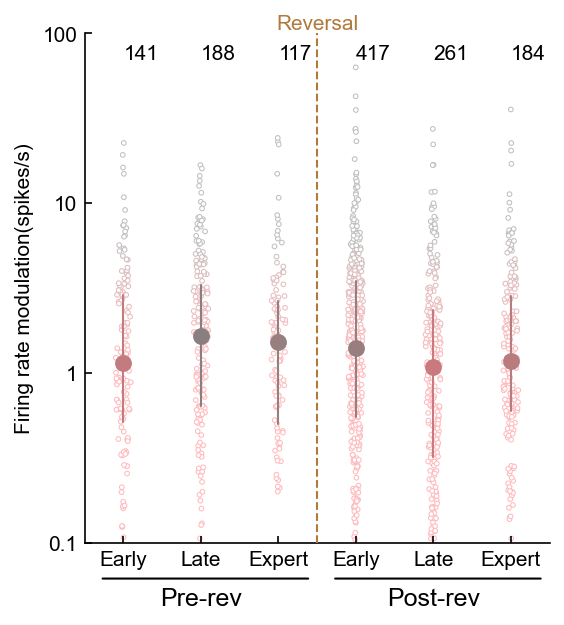

In [338]:
#Firing rate modulation graphs

size=5

ramping_baseline_median = np.nanmedian(np.abs(ramping_preearly))
print('baseline = '+str(ramping_baseline_median))

fig, ax = plt.subplots(figsize=(4,4.5))
data = [ramping_preearly,ramping_prelate,ramping_preexpert,ramping_postearly,ramping_postlate,ramping_postexpert]
data = [np.abs(column[np.isfinite(column)]) for column in data]
#num_animal = [preearly_animal_num,prelate_animal_num,preexpert_animal_num,postearly_animal_num,postlate_animal_num,postexpert_animal_num]
labels = ['Early','Late','Expert','Early','Late','Expert']
numCon = len(data)
X = [np.ones(len(l))*idx for idx,l in enumerate(data)]

_,Y = ilep.violin(np.concatenate(X),np.concatenate(data),width=0.25)
X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data)),width=0.25)
colors = NCR_CR_cmap((Y-1)/5)

ax.scatter(X, Y, s=size, ec=colors, fc='white', lw=0.5,zorder=-10)
ax.set_yscale('log',subs=[])

#Plot summary
for idx,column in enumerate(data):
    percentCR = np.nanmean(np.greater(column,ramping_baseline_median))*100
    
    eye_color=NCR_CR_cmap((percentCR-40)/20)
    
    r,g,b = mpl.colors.to_rgb(eye_color)
    h,l,s = colorsys.rgb_to_hls(r,g,b)
    #border_color=colorsys.hls_to_rgb(h,l*0.5,s)
    border_color=colorsys.hls_to_rgb(h,l,s)

    summary_size=50
    summary_width=1
    
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    
    ax.scatter([idx], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx, idx], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')

ax.axvline(2.5,color=SWITCH_COLOR,linestyle='--',zorder=10,lw=1)

ax.set_ylim([0.1,100])
ax.set_yticks([0.1,1,10,100])
ax.set_yticklabels(['0.1','1','10','100'])
ax.set_ylabel('Firing rate modulation(spikes/s)')

ax.set_xlim([-0.5,5.5])
ax.set_xticks(range(numCon))
ax.set_xticklabels(labels)
ax.set_xlim(ax.get_xlim())

# #numbers
#cells
# for idx,column in enumerate(data):
#     ax.text(idx,120,str(len(column)))
# #animals
# for idx,column in enumerate(num_animal):
#     ax.text(idx,95,str(column))
    
ax.fill_between(ax.get_xlim(),[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]]*2,color='white',alpha=0.5,zorder=-5)
#ax.axhline(ramping_baseline_median,color='k',linestyle='--',lw=1,zorder=-4)
ax.text(2.5,ax.get_ylim()[1],'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='bottom')
#statistics
#ax.text(1,105,str('n.s.'))
#ax.text(2,105,str('n.s.'))
#ax.text(3,105,str('n.s.'))
#ax.text(4,105,str('n.s.'))
#ax.text(5,105,str('n.s.'))

ax.text(0,70,str(len(ramping_preearly)))
ax.text(1,70,str(len(ramping_prelate)))
ax.text(2,70,str(len(ramping_preexpert)))
ax.text(3,70,str(len(ramping_postearly)))
ax.text(4,70,str(len(ramping_postlate)))
ax.text(5,70,str(len(ramping_postexpert)))

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
ax.text(xtick_pos_pre, 0.055, 'Pre-rev', ha='center', va='top', fontsize=12)
ax.text(xtick_pos_post, 0.055, 'Post-rev', ha='center', va='top',  fontsize=12)
ax.annotate('', xy=(0.03, -0.07), xycoords='axes fraction', xytext=(0.49, -0.07),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -0.07), xycoords='axes fraction', xytext=(0.99, -0.07),arrowprops=dict(arrowstyle='-', color='black'))

#plt.tight_layout()
fig.savefig(os.path.join('D:\\\\Figures','Ramping Figures','FR modulations','AC choice modulation all cells over learning.png'),transparent=False,facecolor="white")
fig.savefig(os.path.join('D:\\\\Figures','Ramping Figures','FR modulations','AC choice modulation all cells over learning.pdf'),transparent=False,facecolor="white")

In [366]:
data = SimpleNamespace(prereversal_early=np.abs(ramping_preearly),
                      prereversal_late=np.abs(ramping_prelate),
                      prereversal_expert=np.abs(ramping_preexpert),
                      postreversal_early=np.abs(ramping_postearly),
                      postreversal_late=np.abs(ramping_postlate),
                      postreversal_expert=np.abs(ramping_postexpert)
                     )

In [367]:
phase = len(data.prereversal_early)*["pre-early"] + len(data.prereversal_late)*["pre-late"] + len(data.prereversal_expert)*["pre-expert"] \
        + len(data.postreversal_early)*["post-early"] + len(data.postreversal_late)*["post-late"] + len(data.postreversal_expert)*["post-expert"]
context = len(data.prereversal_early)*["pre"] + len(data.prereversal_late)*["pre"] + len(data.prereversal_expert)*["pre"] \
        + len(data.postreversal_early)*["post"] + len(data.postreversal_late)*["post"] + len(data.postreversal_expert)*["post"]
mod = (np.concatenate([data.prereversal_early, data.prereversal_late, data.prereversal_expert, data.postreversal_early, data.postreversal_late, data.postreversal_expert]))

df = pd.DataFrame({"phase": phase, "context": context, "FR_mod": mod})
#df.to_csv('C:\\\\Users\\insan\\Desktop\\DataForStatsTestRamping.csv')

In [368]:
pg.anova(data=df, dv='FR_mod', between=['phase'], detailed=True)

,Source,SS,DF,MS,F,p-unc,np2
0,phase,150.747462,5,30.149492,1.708857,0.129523,0.00652
1,Within,22971.283124,1302,17.643075,NaN,NaN,NaN


In [342]:
context_results = pg.pairwise_tests(data=df, dv='FR_mod', between=['phase'], parametric=True, padjust='fdr_bh')

In [343]:
# Conducting pairwise tests using Benjamini/Hochberg FDR correction to Mann-Whitney U

pairwise_mwu = pg.pairwise_tests(data=df, dv='FR_mod', between="phase", padjust="fdr_bh", parametric=False, )

pairwise_mwu[pairwise_mwu["p-corr"] <= 0.05][["A", "B", "p-corr", "hedges"]]
#pairwise_mwu[:][["A", "B","p-unc", "p-corr", "hedges"]]

,A,B,p-corr,hedges
1,post-early,post-late,0.006473,0.196237
11,post-late,pre-late,0.005448,-0.179281


<ipython-input-344-b9859c3da875>:19: RuntimeWarning: invalid value encountered in log10
  X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data)),width=0.25)


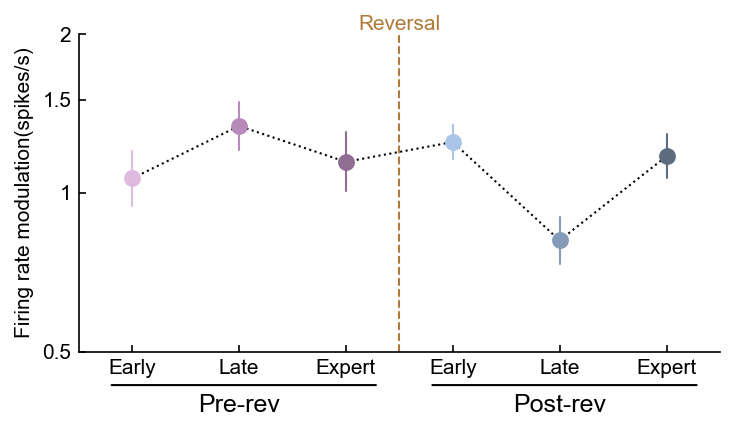

In [344]:
#Firing rate modulation graphs

size=5

FRmod_baseline_median = 3.4986225895316823#np.median(FRmod_preearly)
labels = ['Early','Late','Expert','Early','Late','Expert']
offset_distance = 0#0.05

fig, ax = plt.subplots(figsize=(5,3))

data = [ramping_preearly,ramping_prelate,ramping_preexpert,ramping_postearly,ramping_postlate,ramping_postexpert]
data = [np.abs(column[np.isfinite(column)]) for column in data]
data = [np.log10(d) for d in data]
num_animals = [preearly_animals_num,prelate_animals_num,preexpert_animals_num,postearly_animals_num,postlate_animals_num,postexpert_animals_num]
numCon = len(data)
X = [np.ones(len(l))*idx for idx,l in enumerate(data)]

_,Y = ilep.violin(np.concatenate(X),np.concatenate(data),width=0.25)
X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data)),width=0.25)
colors = NCR_CR_cmap((Y-1)/5)

#ax.scatter(X-0.125, Y, s=size, ec=colors, fc='white', lw=0.5,zorder=-10)
#ax.set_yscale('log',subs=[])

#Plot summary
for idx,column in enumerate(data):
    percentCR = np.nanmean(np.greater(column,FRmod_baseline_median))*100
    
    #eye_color=NCR_CR_cmap((percentCR-40)/20)
    eye_color = PHASE_COLORS[idx]
    
    r,g,b = mpl.colors.to_rgb(eye_color)
    h,l,s = colorsys.rgb_to_hls(r,g,b)
    border_color=eye_color#colorsys.hls_to_rgb(h,l*0.5,s)
    
    #eye_color='k'
    #border_color='k'

    summary_size=50
    summary_width=1
    
    #Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    median = np.mean(column)
    Q1 = median - sem(column)
    Q3 = median + sem(column)
    
    ax.scatter([idx-offset_distance], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx-offset_distance, idx-offset_distance], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    #ax.plot([idx-offset_distance-0.05, idx-offset_distance+0.05], [Q1, Q1], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    #ax.plot([idx-offset_distance-0.05, idx-offset_distance+0.05], [Q3, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
medians = [np.mean(col) for col in data]
plt.plot(np.linspace(0,5,6)-offset_distance,medians,color='k',linestyle=':',lw=1)
    
######################################################################################################################################################

ax.axvline(2.5,color=SWITCH_COLOR,linestyle='--',zorder=-10,lw=1)
#
#ax.set_ylim([0.1,100])
#ax.set_yticks([0.1,1,10,100])
#ax.set_yticklabels(['0.1','1','10','100'])
ax.set_ylabel('Firing rate modulation(spikes/s)')
#ax.set_ylim([2,10])
#ax.set_yticks([2,4,6,8,10])
#ax.set_yticks([0.1,1,10,100])
#ax.set_yticklabels(['0.1','1','10','100'])

ax.set_xlim([-0.5,5.5])
ax.set_xticks(range(numCon))
ax.set_xticklabels(labels)
ax.set_xlim(ax.get_xlim())

#numbers
#cells
#for idx,(column1,column2) in enumerate(zip(data,passive_data)):
#    #ax.text(idx,120,str(len(column1))+'/'+str(len(column2)),fontsize=8)
#    ax.text(idx,12,str(len(column1))+'/'+str(len(column2)),fontsize=6)
##animals
#for idx,(column1,column2) in enumerate(zip(num_animals,num_passive_animal)):
#    #ax.text(idx,95,str(column1)+'/'+str(column2),fontsize=8)
#    ax.text(idx,11.75,str(column1)+'/'+str(column2),fontsize=6)
    
#ax.fill_between(ax.get_xlim(),[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]]*2,color='white',alpha=0.5,zorder=-5)
#ax.axhline(FRmod_baseline_median,color='k',linestyle='--',lw=1,zorder=-4)

# ax.scatter([],[],ec='grey',fc='white',s=summary_size,lw=summary_width,zorder=10,marker='o',label='passive')
# ax.scatter([],[],ec='grey',fc='grey',s=summary_size,lw=summary_width,zorder=10,marker='o',label='behaving')
# ax.legend(frameon=False,loc=(1,0.9))

# for idx,(column1,column2) in enumerate(zip(data,passive_data)):
#     pval = mannwhitneyu(column1,column2).pvalue
#     print(pval)
    
#statistics
# print(0.05/6)
# ax.text(0,0.75,str('n.s.'),verticalalignment='bottom',horizontalalignment='center')
# ax.text(1,np.log10(3),str('****'),verticalalignment='bottom',horizontalalignment='center')
# ax.text(2,np.log10(2.65),str('****'),verticalalignment='bottom',horizontalalignment='center')
# ax.text(3,np.log10(3.15),str('n.s.'),verticalalignment='bottom',horizontalalignment='center')
# ax.text(4,np.log10(1.85),str('****'),verticalalignment='bottom',horizontalalignment='center')
# ax.text(5,np.log10(2.65),str('****'),verticalalignment='bottom',horizontalalignment='center')

#ax.text(-0.4,9.5,'CR',color=CR_COLOR,horizontalalignment='left',verticalalignment='top')
#ax.text(-0.4,0.5,'NCR',color=NCR_COLOR,horizontalalignment='left',verticalalignment='bottom')

#ax.set_yscale('log',subs=[])
#ax.set_ylim([2,10])
# ax.set_yticks(np.log10([1.5,2,2.5,3]))
# ax.set_yticklabels([1.5,2,2.5,3])
# ax.set_ylim([np.log10(1.4),np.log10(3)])

ax.set_yticks(np.log10([0.5,1,1.5,2]))
ax.set_yticklabels([0.5,1,1.5,2])
ax.set_ylim([np.log10(0.5),np.log10(2)])


#ax.annotate('', xy=(0.03, -0.095), xycoords='axes fraction', xytext=(0.48, -0.095),arrowprops=dict(arrowstyle='-', color='black'))
#ax.annotate('', xy=(0.53, -0.095), xycoords='axes fraction', xytext=(0.98, -0.095),arrowprops=dict(arrowstyle='-', color='black'))
ax.text(2.5,ax.get_ylim()[1],'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='bottom')

#ax.fill_between([2.5,5.5],[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]]*2,color=SWITCH_COLOR,alpha=0.2,lw=0)

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
yval = -0.3811320082238532
ax.text(xtick_pos_pre, yval, 'Pre-rev', ha='center', va='top', fontsize=12)
ax.text(xtick_pos_post, yval, 'Post-rev', ha='center', va='top',  fontsize=12)
ax.annotate('', xy=(0.045, -0.105), xycoords='axes fraction', xytext=(0.47, -0.105),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.545, -0.105), xycoords='axes fraction', xytext=(0.97, -0.105),arrowprops=dict(arrowstyle='-', color='black'))

plt.tight_layout()
fig.savefig(os.path.join('D:\\Figures','Ramping Figures','Choice modulation over learning.pdf'),transparent=False,facecolor="white")

In [345]:
#Stimulus

FRmod_baseline_median = np.median(FRmod_preearly)
print('baseline: '+str(FRmod_baseline_median))

#These numbers are essentially %CR
FRmod_preearly_pc = np.nanmean(np.greater(FRmod_preearly,FRmod_baseline_median))
FRmod_prelate_pc = np.nanmean(np.greater(FRmod_prelate,FRmod_baseline_median))
FRmod_preexpert_pc = np.nanmean(np.greater(FRmod_preexpert,FRmod_baseline_median))
FRmod_postearly_pc = np.nanmean(np.greater(FRmod_postearly,FRmod_baseline_median))
FRmod_postlate_pc = np.nanmean(np.greater(FRmod_postlate,FRmod_baseline_median))
FRmod_postexpert_pc = np.nanmean(np.greater(FRmod_postexpert,FRmod_baseline_median))
print(FRmod_preearly_pc)
print(FRmod_prelate_pc)
print(FRmod_preexpert_pc)
print(FRmod_postearly_pc)
print(FRmod_postlate_pc)
print(FRmod_postexpert_pc)


#Choice 

ramping_baseline_median = np.nanmedian(np.abs(ramping_preearly))
print('baseline: '+str(ramping_baseline_median))

#These numbers are essentially %CR
ramping_preearly_pc = np.nanmean(np.greater(np.abs(ramping_preearly),ramping_baseline_median))
ramping_prelate_pc = np.nanmean(np.greater(np.abs(ramping_prelate),ramping_baseline_median))
ramping_preexpert_pc = np.nanmean(np.greater(np.abs(ramping_preexpert),ramping_baseline_median))
ramping_postearly_pc = np.nanmean(np.greater(np.abs(ramping_postearly),ramping_baseline_median))
ramping_postlate_pc = np.nanmean(np.greater(np.abs(ramping_postlate),ramping_baseline_median))
ramping_postexpert_pc = np.nanmean(np.greater(np.abs(ramping_postexpert),ramping_baseline_median))
print(ramping_preearly_pc)
print(ramping_prelate_pc)
print(ramping_preexpert_pc)
print(ramping_postearly_pc)
print(ramping_postlate_pc)
print(ramping_postexpert_pc)

baseline: 3.4758144364751598
0.5
0.39361702127659576
0.46153846153846156
0.47002398081534774
0.35877862595419846
0.34782608695652173
baseline: 1.1528258064516133
0.49645390070921985
0.5851063829787234
0.5641025641025641
0.5611510791366906
0.4827586206896552
0.5108695652173914


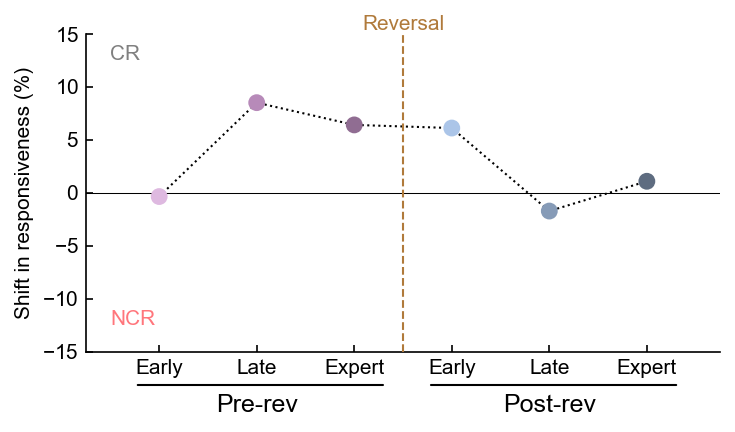

In [346]:
fig, ax = plt.subplots(figsize=(5,3))
labels = ['Early','Late','Expert','Early','Late','Expert']
#colors = phase_colors = ['#DEB9E0','#B78AB9','#906D92','#ABC5E8','#869BB7','#5E6C80']

percentCR = np.array([ramping_preearly_pc,ramping_prelate_pc,ramping_preexpert_pc,ramping_postearly_pc,ramping_postlate_pc,ramping_postexpert_pc])*100
numCon = len(labels)
ax.plot([0,1,2,3,4,5],(percentCR-50),color='k',linestyle=':',lw=1,alpha=1)

color=NCR_CR_cmap((percentCR-40)/20)
ax.scatter([0,1,2,3,4,5],(percentCR-50),c=PHASE_COLORS,s=50,zorder=10,marker='o',lw=1)




xlims = [-0.75,numCon-0.25]
ax.set_xlim(xlims)
ax.set_xticks(range(numCon))
ax.set_xticklabels(labels)

#All cells with All Cells baseline
# ax.set_ylabel('Shift in responsiveness (%)')
# ax.set_ylim([-20,20])
# ax.set_yticks([-20,-10,0,10,20])
# ax.text(-0.5,17.5,'CR',color=CR_COLOR)
# ax.text(-0.5,-17.5,'NCR',color=NCR_COLOR)
ax.set_ylabel('Shift in responsiveness (%)')
ax.set_ylim([-15,15])
ax.set_yticks([-15,-10,-5,0,5,10,15])
ax.text(-0.5,12.5,'CR',color=CR_COLOR)
ax.text(-0.5,-12.5,'NCR',color=NCR_COLOR)


# ax.annotate('', xy=(0.07, -0.08), xycoords='axes fraction', xytext=(0.48, -0.08),arrowprops=dict(arrowstyle='-', color='black'))
# ax.annotate('', xy=(0.53, -0.08), xycoords='axes fraction', xytext=(0.94, -0.08),arrowprops=dict(arrowstyle='-', color='black'))
ax.text(2.5,ax.get_ylim()[1],'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='bottom')

#ax.plot([2.5,2.5],ax.get_ylim(),color='blue',lw=1,zorder=-15)

ax.axvline(2.5,color=SWITCH_COLOR,linestyle='--',zorder=10,lw=1)
ax.axhline(0,c='k',linestyle='-',lw=0.5,zorder=-10)

# ax.scatter([],[],fc='white',ec='grey',s=50,marker='o',lw=1,label='passive')
# ax.scatter([],[],fc='grey',ec='grey',s=50,marker='o',lw=1,label='behaving')
# ax.legend(frameon=False,loc=(1,0.85))

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
ax.text(xtick_pos_pre, -19, 'Pre-rev', ha='center', va='top', fontsize=12)
ax.text(xtick_pos_post, -19, 'Post-rev', ha='center', va='top',  fontsize=12)
ax.annotate('', xy=(0.075, -0.105), xycoords='axes fraction', xytext=(0.475, -0.105),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.5375, -0.105), xycoords='axes fraction', xytext=(0.9375, -0.105),arrowprops=dict(arrowstyle='-', color='black'))

plt.tight_layout()
plt.savefig(os.path.join('D:\\\\Figures','Ramping Figures','Shift in responsiveness','AC Shift in choice responsiveness all cells.pdf'),transparent=False,facecolor="white")

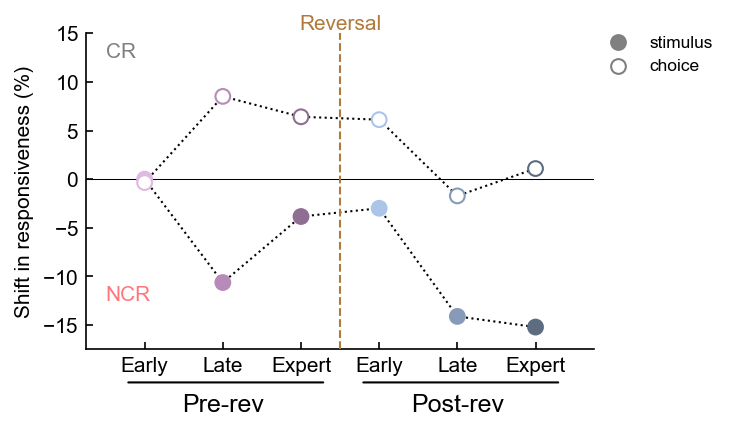

In [353]:
fig, ax = plt.subplots(figsize=(5,3))
labels = ['Early','Late','Expert','Early','Late','Expert']
#colors = phase_colors = ['#DEB9E0','#B78AB9','#906D92','#ABC5E8','#869BB7','#5E6C80']

percentCRstim = np.array([FRmod_preearly_pc,FRmod_prelate_pc,FRmod_preexpert_pc,FRmod_postearly_pc,FRmod_postlate_pc,FRmod_postexpert_pc])*100
numCon = len(labels)
ax.plot([0,1,2,3,4,5],(percentCRstim-50),color='k',linestyle=':',lw=1,alpha=1)

color=NCR_CR_cmap((percentCRstim-40)/20)
ax.scatter([0,1,2,3,4,5],(percentCRstim-50),c=PHASE_COLORS,s=50,zorder=10,marker='o',lw=1)



percentCRchoice = np.array([ramping_preearly_pc,ramping_prelate_pc,ramping_preexpert_pc,ramping_postearly_pc,ramping_postlate_pc,ramping_postexpert_pc])*100
numCon = len(labels)
ax.plot([0,1,2,3,4,5],(percentCRchoice-50),color='k',linestyle=':',lw=1,alpha=1)

color=NCR_CR_cmap((percentCRchoice-40)/20)
ax.scatter([0,1,2,3,4,5],(percentCRchoice-50),fc='white',ec=PHASE_COLORS,s=50,zorder=10,marker='o',lw=1)





xlims = [-0.75,numCon-0.25]
ax.set_xlim(xlims)
ax.set_xticks(range(numCon))
ax.set_xticklabels(labels)

#All cells with All Cells baseline
# ax.set_ylabel('Shift in responsiveness (%)')
# ax.set_ylim([-20,20])
# ax.set_yticks([-20,-10,0,10,20])
# ax.text(-0.5,17.5,'CR',color=CR_COLOR)
# ax.text(-0.5,-17.5,'NCR',color=NCR_COLOR)
ax.set_ylabel('Shift in responsiveness (%)')
ax.set_ylim([-17.5,15])
ax.set_yticks([-15,-10,-5,0,5,10,15])
ax.text(-0.5,12.5,'CR',color=CR_COLOR)
ax.text(-0.5,-12.5,'NCR',color=NCR_COLOR)


# ax.annotate('', xy=(0.07, -0.08), xycoords='axes fraction', xytext=(0.48, -0.08),arrowprops=dict(arrowstyle='-', color='black'))
# ax.annotate('', xy=(0.53, -0.08), xycoords='axes fraction', xytext=(0.94, -0.08),arrowprops=dict(arrowstyle='-', color='black'))
ax.text(2.5,ax.get_ylim()[1],'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='bottom')

#ax.plot([2.5,2.5],ax.get_ylim(),color='blue',lw=1,zorder=-15)

ax.axvline(2.5,color=SWITCH_COLOR,linestyle='--',zorder=10,lw=1)
ax.axhline(0,c='k',linestyle='-',lw=0.5,zorder=-10)

ax.scatter([],[],fc='grey',ec='grey',s=50,marker='o',lw=1,label='stimulus')
ax.scatter([],[],fc='white',ec='grey',s=50,marker='o',lw=1,label='choice')
ax.legend(frameon=False,loc=(1,0.85))

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
ax.text(xtick_pos_pre, -22, 'Pre-rev', ha='center', va='top', fontsize=12)
ax.text(xtick_pos_post, -22, 'Post-rev', ha='center', va='top',  fontsize=12)
ax.annotate('', xy=(0.075, -0.105), xycoords='axes fraction', xytext=(0.475, -0.105),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.5375, -0.105), xycoords='axes fraction', xytext=(0.9375, -0.105),arrowprops=dict(arrowstyle='-', color='black'))

plt.tight_layout()
plt.savefig(os.path.join('D:\\\\Figures','Ramping Figures','Shift in responsiveness','AC Shift in both responsiveness all cells.pdf'),transparent=False,facecolor="white")

The following code is used for determining "Pre-rev" and "Post-rev" text placement. It is kept out of convenience

In [320]:
ymax = np.log10(3)
ymin = np.log10(1.4)
yrange = ymax-ymin
print(yrange)
oldval = np.log10(1.265)
print(oldval)
olddisp = oldval - ymin
print(olddisp)
olddispfrac = olddisp / yrange
print(olddispfrac)

ymin2 = np.log10(0.5)
ymax2 = np.log10(2)
yrange2 = ymax2-ymin2
print(yrange2)
newval = olddispfrac * yrange2 + ymin2
print(newval)
#ax.text(xtick_pos_pre, np.log10(1.265), 'Pre-rev', ha='center', va='top', fontsize=12)

0.3309932190414244
0.10209052551183669
-0.044037510166401325
-0.13304656298982956
0.6020599913279624
-0.3811320082238532


# FR Modulation Index (Stimulus + Choice euclidean combination)

baseline = 4.423814752692245


Text(0.99, -0.07, '')

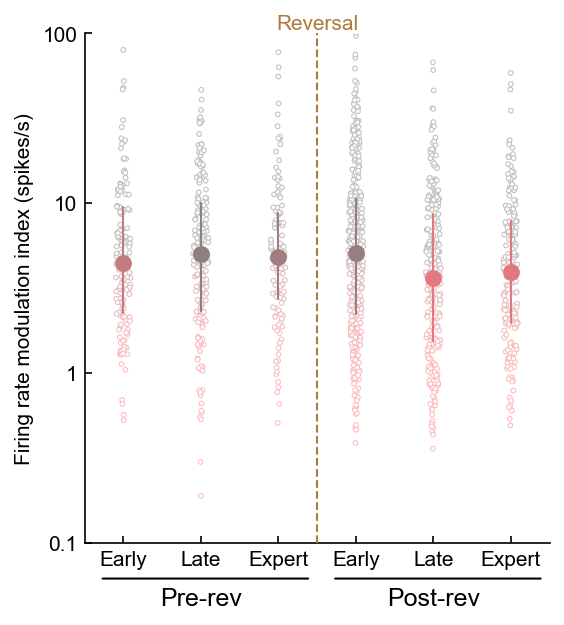

In [294]:
#Firing rate modulation graphs

size=5

FRmodInd_baseline_median = np.nanmedian(np.abs(FRmodInd_preearly))
print('baseline = '+str(FRmodInd_baseline_median))

fig, ax = plt.subplots(figsize=(4,4.5))
data = [FRmodInd_preearly,FRmodInd_prelate,FRmodInd_preexpert,FRmodInd_postearly,FRmodInd_postlate,FRmodInd_postexpert]
data = [np.abs(column[np.isfinite(column)]) for column in data]
#num_animal = [preearly_animal_num,prelate_animal_num,preexpert_animal_num,postearly_animal_num,postlate_animal_num,postexpert_animal_num]
labels = ['Early','Late','Expert','Early','Late','Expert']
numCon = len(data)
X = [np.ones(len(l))*idx for idx,l in enumerate(data)]

_,Y = ilep.violin(np.concatenate(X),np.concatenate(data),width=0.25)
X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data)),width=0.25)
colors = NCR_CR_cmap((Y-1)/5)

ax.scatter(X, Y, s=size, ec=colors, fc='white', lw=0.5,zorder=-10)
ax.set_yscale('log',subs=[])

#Plot summary
for idx,column in enumerate(data):
    percentCR = np.nanmean(np.greater(column,FRmodInd_baseline_median))*100
    
    eye_color=NCR_CR_cmap((percentCR-40)/20)
    
    r,g,b = mpl.colors.to_rgb(eye_color)
    h,l,s = colorsys.rgb_to_hls(r,g,b)
    #border_color=colorsys.hls_to_rgb(h,l*0.5,s)
    border_color=colorsys.hls_to_rgb(h,l,s)

    summary_size=50
    summary_width=1
    
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    
    ax.scatter([idx], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx, idx], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')

ax.axvline(2.5,color=SWITCH_COLOR,linestyle='--',zorder=10,lw=1)

ax.set_ylim([0.1,100])
ax.set_yticks([0.1,1,10,100])
ax.set_yticklabels(['0.1','1','10','100'])
ax.set_ylabel('Firing rate modulation index (spikes/s)')

ax.set_xlim([-0.5,5.5])
ax.set_xticks(range(numCon))
ax.set_xticklabels(labels)
ax.set_xlim(ax.get_xlim())

# #numbers
#cells
# for idx,column in enumerate(data):
#     ax.text(idx,120,str(len(column)))
# #animals
# for idx,column in enumerate(num_animal):
#     ax.text(idx,95,str(column))
    
ax.fill_between(ax.get_xlim(),[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]]*2,color='white',alpha=0.5,zorder=-5)
#ax.axhline(ramping_baseline_median,color='k',linestyle='--',lw=1,zorder=-4)
ax.text(2.5,ax.get_ylim()[1],'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='bottom')
#statistics
#ax.text(1,105,str('n.s.'))
#ax.text(2,105,str('n.s.'))
#ax.text(3,105,str('n.s.'))
#ax.text(4,105,str('n.s.'))
#ax.text(5,105,str('n.s.'))

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
ax.text(xtick_pos_pre, 0.055, 'Pre-rev', ha='center', va='top', fontsize=12)
ax.text(xtick_pos_post, 0.055, 'Post-rev', ha='center', va='top',  fontsize=12)
ax.annotate('', xy=(0.03, -0.07), xycoords='axes fraction', xytext=(0.49, -0.07),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -0.07), xycoords='axes fraction', xytext=(0.99, -0.07),arrowprops=dict(arrowstyle='-', color='black'))

#plt.tight_layout()
#fig.savefig(os.path.join('D:\\\\Figures','Ramping Figures','FR modulations','AC joint modulation all cells over learning.png'),transparent=False,facecolor="white")
#fig.savefig(os.path.join('D:\\\\Figures','Ramping Figures','FR modulations','AC joint modulation all cells over learning.pdf'),transparent=False,facecolor="white")

In [154]:
data = SimpleNamespace(prereversal_early=FRmodInd_preearly,
                      prereversal_late=FRmodInd_prelate,
                      prereversal_expert=FRmodInd_preexpert,
                      postreversal_early=FRmodInd_postearly,
                      postreversal_late=FRmodInd_postlate,
                      postreversal_expert=FRmodInd_postexpert
                     )

In [155]:
phase = len(data.prereversal_early)*["pre-early"] + len(data.prereversal_late)*["pre-late"] + len(data.prereversal_expert)*["pre-expert"] \
        + len(data.postreversal_early)*["post-early"] + len(data.postreversal_late)*["post-late"] + len(data.postreversal_expert)*["post-expert"]
context = len(data.prereversal_early)*["pre"] + len(data.prereversal_late)*["pre"] + len(data.prereversal_expert)*["pre"] \
        + len(data.postreversal_early)*["post"] + len(data.postreversal_late)*["post"] + len(data.postreversal_expert)*["post"]
mod = (np.concatenate([data.prereversal_early, data.prereversal_late, data.prereversal_expert, data.postreversal_early, data.postreversal_late, data.postreversal_expert]))

df = pd.DataFrame({"phase": phase, "context": context, "FR_mod": mod})
df.to_csv('C:\\\\Users\\insan\\Desktop\\DataForStatsTestFRmodInd.csv')

In [156]:
pg.anova(data=df, dv='FR_mod', between=['phase'], detailed=True)

,Source,SS,DF,MS,F,p-unc,np2
0,phase,2519.543921,5,503.908784,3.320828,0.00551,0.012592
1,Within,197567.949277,1302,151.741897,NaN,NaN,NaN


In [157]:
context_results = pg.pairwise_tests(data=df, dv='FR_mod', between=['phase'], parametric=True, padjust='fdr_bh')

In [158]:
# Conducting pairwise tests using Benjamini/Hochberg FDR correction to Mann-Whitney U

pairwise_mwu = pg.pairwise_tests(data=df, dv='FR_mod', between="phase", padjust="fdr_bh", parametric=False, )

pairwise_mwu[pairwise_mwu["p-corr"] <= 0.05][["A", "B", "p-corr", "hedges"]]
#pairwise_mwu[:][["A", "B", "p-corr", "hedges"]]

,A,B,p-corr,hedges
0,post-early,post-expert,0.031452,0.213149
1,post-early,post-late,0.004064,0.251800
8,post-expert,pre-late,0.049074,-0.100795
10,post-late,pre-expert,0.049074,-0.174535
11,post-late,pre-late,0.021506,-0.153011


# 2-axis Stimulus/Choice Plots

-0.06574283426486871
0.7482071292805752


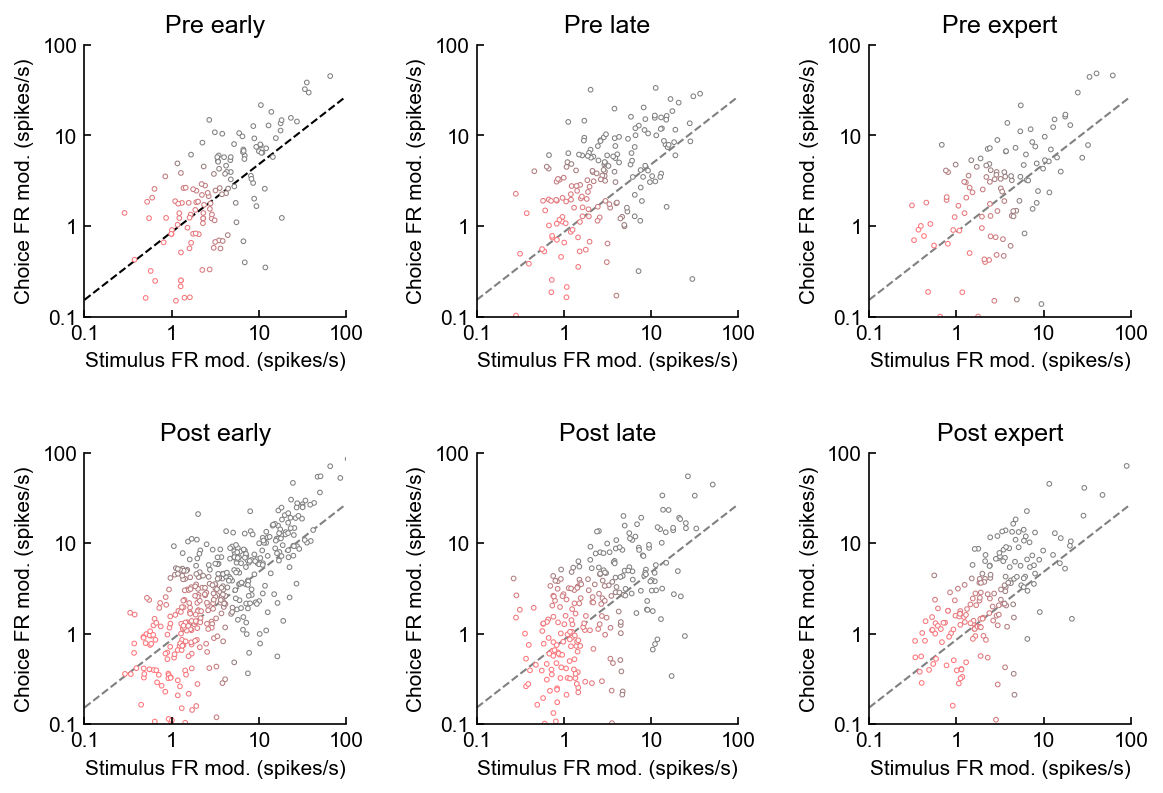

In [159]:
phase_labels = ['Pre early','Pre late','Pre expert','Post early','Post late','Post expert']

fig = plt.figure(figsize=(9,6))
gs = fig.add_gridspec(2,3,hspace=0.5,wspace=0.5)
axs = [plt.subplot(gs[x,y]) for x,y in product(range(2),range(3))]
for ax in axs:
    #ax.spines['bottom'].set_visible(False)
    #ax.get_xaxis().set_visible(False)
    #ax.spines['left'].set_visible(False)
    #ax.get_yaxis().set_visible(False)
    pass
    

data_stim = [FRmod_preearly,FRmod_prelate,FRmod_preexpert,FRmod_postearly,FRmod_postlate,FRmod_postexpert]
data_cho = [ramping_preearly,ramping_prelate,ramping_preexpert,ramping_postearly,ramping_postlate,ramping_postexpert]
data_cho = [np.abs(column) for column in data_cho]
    
finite_mask = np.logical_and(np.isfinite(FRmod_preearly),np.isfinite(ramping_preearly))
finite_X = np.log10(np.abs(FRmod_preearly[finite_mask]))
finite_Y = np.log10(np.abs(ramping_preearly[finite_mask]))
X = np.matrix([np.ones_like(finite_X) , finite_X]).T
Y = np.matrix(finite_Y).T
LSE = np.array(np.linalg.inv(X.T@X) @ (X.T@Y))
baseline = (LSE[0][0])
slope = (LSE[1][0])
print(baseline)
print(slope)
    
for ax,col_stim,col_cho,label in zip(axs,data_stim,data_cho,phase_labels):
    FRmodInd = np.sqrt(np.power(col_stim,2)+np.power(col_cho,2))
    colors = NCR_CR_cmap((FRmodInd-1)/5)
    ax.scatter(col_stim,col_cho, s=size, ec=colors, fc='white', lw=0.5,zorder=0)

    ax.set_yscale('log',subs=[])
    ax.set_xscale('log',subs=[])
    
    ax.set_xlim([0.1,100])
    ax.set_xticks([0.1,1,10,100])
    ax.set_xticklabels(['0.1','1','10','100'])
    ax.set_xlabel('Stimulus FR mod. (spikes/s)')
    
    ax.set_ylim([0.1,100])
    ax.set_yticks([0.1,1,10,100])
    ax.set_yticklabels(['0.1','1','10','100'])
    ax.set_ylabel('Choice FR mod. (spikes/s)')
    
    ax.set_title(label)
    
    if label == 'Pre early':
        xrange = np.logspace(-1,2,1000)
        ax.plot(xrange,10**(baseline+slope*np.log10(xrange))  ,color='k',lw=1,linestyle='--',zorder=-10)
    else:
        xrange = np.logspace(-1,2,1000)
        ax.plot(xrange,10**(baseline+slope*np.log10(xrange))  ,color='grey',lw=1,linestyle='--',zorder=-10)
    #ax.plot([0,100],[0,100],color='k',lw=1,linestyle='--',zorder=-10)
    
#fig.savefig(os.path.join('D:\\\\Figures','Ramping Figures','FR modulations','two-axis joint modulation across learning.pdf'),transparent=False,facecolor="white")
#fig.savefig(os.path.join('D:\\\\Figures','Ramping Figures','FR modulations','two-axis joint modulation across learning.png'),transparent=False,facecolor="white")

(array([17., 14.,  9., 13.,  9.,  9.,  6.,  3.,  5.,  4.,  2.,  2.,  3.,
         1.,  1.,  1.,  2.,  0.,  2.,  1.,  1.,  1.,  1.,  0.,  1.,  0.,
         0.,  0.,  2.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 0.30959752,  0.92849468,  1.54739183,  2.16628898,  2.78518613,
         3.40408328,  4.02298043,  4.64187759,  5.26077474,  5.87967189,
         6.49856904,  7.11746619,  7.73636335,  8.3552605 ,  8.97415765,
         9.5930548 , 10.21195195, 10.83084911, 11.44974626, 12.06864341,
        12.68754056, 13.30643771, 13.92533487, 14.54423202, 15.16312917,
        15.78202632, 16.40092347, 17.01982062, 17.63871778, 18.257614

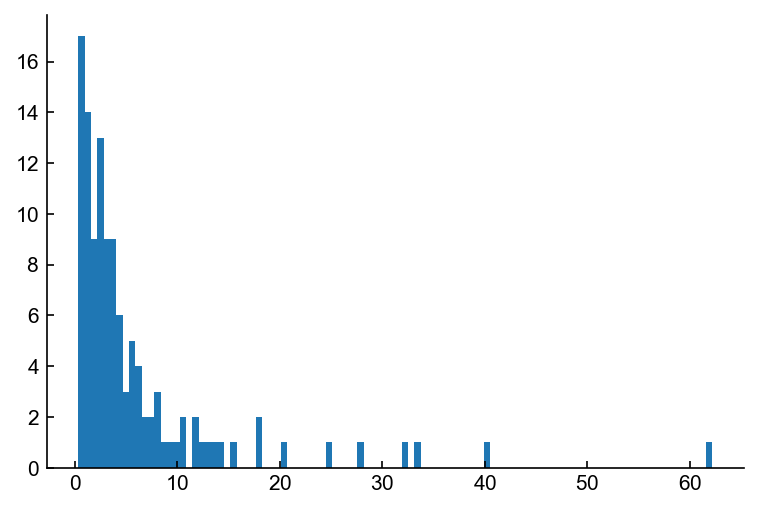

In [148]:
plt.hist(FRmod_preexpert,bins=100)

(array([16., 14., 10.,  9.,  6.,  3.,  8.,  6.,  7.,  5.,  4.,  3.,  1.,
         2.,  4.,  2.,  1.,  1.,  1.,  1.,  0.,  0.,  1.,  0.,  1.,  1.,
         1.,  0.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.]),
 array([ 0.02446792,  0.26629615,  0.50812438,  0.74995261,  0.99178084,
         1.23360907,  1.47543729,  1.71726552,  1.95909375,  2.20092198,
         2.44275021,  2.68457844,  2.92640667,  3.16823489,  3.41006312,
         3.65189135,  3.89371958,  4.13554781,  4.37737604,  4.61920426,
         4.86103249,  5.10286072,  5.34468895,  5.58651718,  5.82834541,
         6.07017363,  6.31200186,  6.55383009,  6.79565832,  7.037486

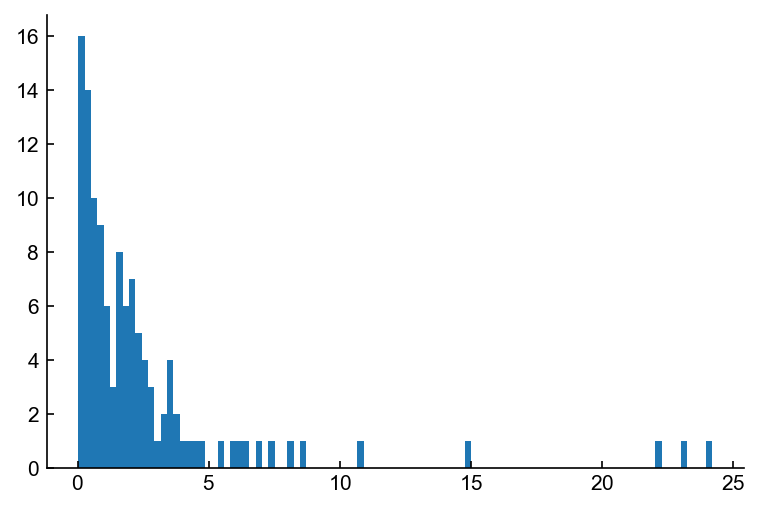

In [150]:
plt.hist(np.abs(ramping_preexpert),bins=100)

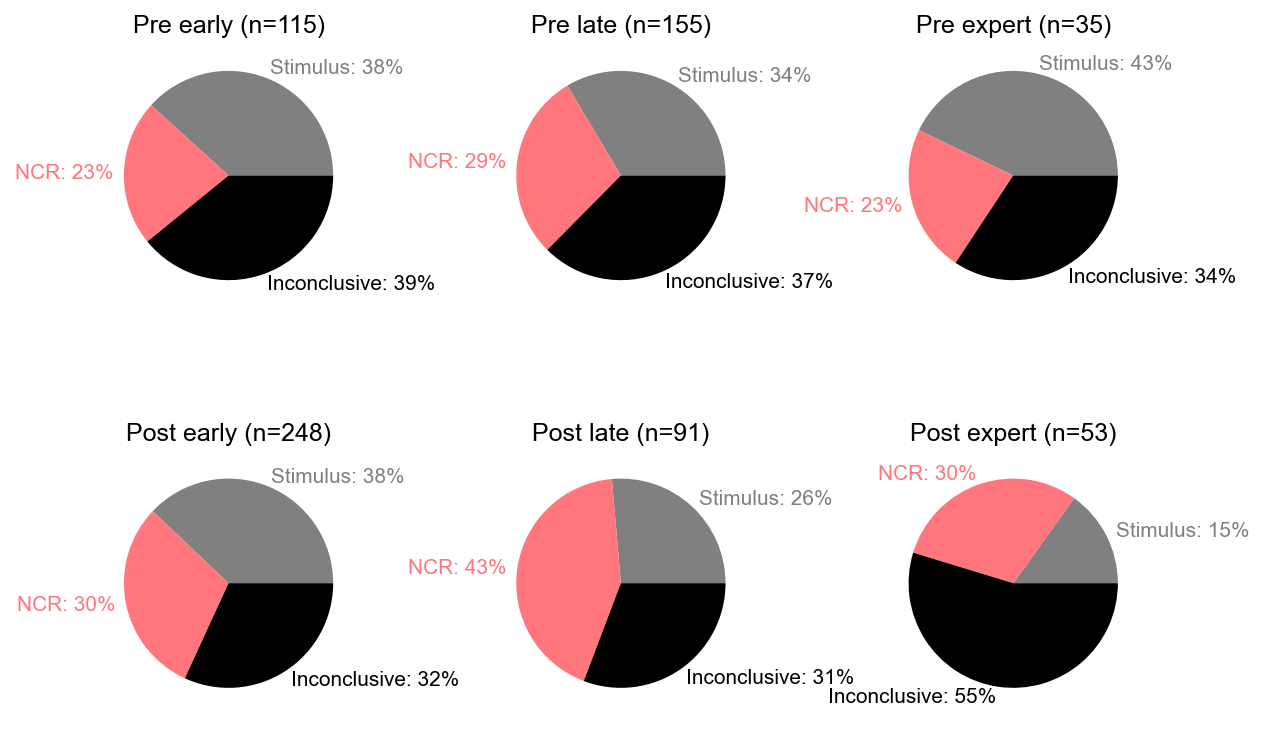

In [46]:
phase_labels = ['Pre early','Pre late','Pre expert','Post early','Post late','Post expert']

fig = plt.figure(figsize=(9,6))
gs = fig.add_gridspec(2,3,hspace=0.5,wspace=0.5)
axs = [plt.subplot(gs[x,y]) for x,y in product(range(2),range(3))]
for ax in axs:
    ax.spines['bottom'].set_visible(False)
    ax.get_xaxis().set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.get_yaxis().set_visible(False)
    
#category_preearly = ['Stimulus','Ramping','NCR','Both','Inconclusive']
#category_prelate = ['Stimulus','Ramping','NCR','Both','Inconclusive']
#category_preexpert = ['Stimulus','Ramping','NCR','Both','Inconclusive']
#category_postearly = ['Stimulus','Ramping','NCR','Both','Inconclusive']
#category_postlate = ['Stimulus','Ramping','NCR','Both','Inconclusive']
#category_postexpert = ['Stimulus','Ramping','NCR','Both','Inconclusive']

categories = [category_preearly,category_prelate,category_preexpert,category_postearly,category_postlate,category_postexpert]

for ax,category_list,phase_label in zip(axs,categories,phase_labels):
    pct_inconclusive = np.mean(np.char.equal(category_list,'Inconclusive'))
    pct_stim = np.mean(np.char.equal(category_list,'Stimulus'))
    pct_ramp = np.mean(np.char.equal(category_list,'Ramping'))
    pct_both = np.mean(np.char.equal(category_list,'Both'))
    pct_ncr = np.mean(np.char.equal(category_list,'NCR'))
    
    #data = [pct_ncr,pct_stim,pct_ramp,pct_both,pct_inconclusive]
    data = [pct_stim+pct_both,pct_ncr+pct_ramp,pct_inconclusive]
    #labels = [f"NCR: {round(pct_ncr*100)}%",f"Stimulus: {round(pct_stim*100)}%",f"Ramping: {round(pct_ramp*100)}%",f"Both: {round(pct_both*100)}%",f"NCR: {round(pct_inconclusive*100)}%"]
    labels = [f"Stimulus: {round((pct_stim+pct_both)*100)}%",f"NCR: {round((pct_ncr+pct_ramp)*100)}%",f"Inconclusive: {round(pct_inconclusive*100)}%"]
    #colors = [NCR_COLOR,CR_COLOR,'green','blue','k']
    colors = [CR_COLOR,NCR_COLOR,'k']
    
    _,ts = ax.pie(data,labels=labels,colors=colors)
    ax.set_title(f"{phase_label} (n={len(category_list)})")

    [t.set_color(colors[idx]) for idx,t in enumerate(ts)]
    
#fig.savefig(os.path.join('D:\\\\Figures','Ramping Figures','Cell categorization across learning.pdf'),transparent=False,facecolor="white")
#fig.savefig(os.path.join('D:\\\\Figures','Ramping Figures','Cell categorization across learning.png'),transparent=False,facecolor="white")
fig.savefig(os.path.join('D:\\\\Figures','Ramping Figures','Cell categorization across learning no ramping.pdf'),transparent=False,facecolor="white")
fig.savefig(os.path.join('D:\\\\Figures','Ramping Figures','Cell categorization across learning no ramping.png'),transparent=False,facecolor="white")